# Temperature forecast for England using time series data: A Deep learning v/s a Machine learning approach

## Table of Contents <a class="anchor" id="0"></a>
* [Introduction](#1) 
* [Necessary Imports](#2)
* [Connecting to ArcGIS](#3)
* [Accessing & Visualizing the required datasets](#4) 
    * [England Boundary](#5)
    * [Weather Stations](#6)
    * [Historic Temperature Data](#7) 
* [Transforming to Timeseries Data](#8)
* [Model Building](#9)
    * [Feature engineering](#10)  
    * [LSTM](#11) 
    * [Temperature forecasted by LSTM model](#12) 
    * [Support Vector Machine(SVR)](#13) 
    * [Temperature forecasted by SVR model](#14)
* [Temperature Interpolation for Whole of England](#15)
* [Result Visualization](#16)
* [Conclusion](#17)
* [Summary of methods used](#18)
* [Data resources](#19)

## Introduction <a class="anchor" id="1"></a>

Weather forecasting has been a significant area for the application of advanced deep learning and machine learning methodologies over traditional methods to improve weather prediction. These new methods are appropriate for processing large chunks of data where massive quantity of historic weather datasets could be utilized for forecasting which remains a challenge for meteorologist. Accordingly, in this sample study two autoregressive methods are attempted: one using a deep learning and another using a machine learning framework to predict temperature of England. 

Subsequently historic temperature data from various weather stations across England are collected and used to forecast daily temperature for the month of October, 2019. The past data consists of daily temperature measurements ranging from February,2005 till September, 2019 which are auto regressed to predict daily temperature for each of the identified stations for the said month. The forecasted temperature obtained for the stations are then spatially interpolated using ArcGIS spatial interpolation tools to produce a temperature prediction surface for the entire country.

## Necessary Imports <a class="anchor" id="2"></a>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from pandas import read_csv
import math
from datetime import datetime
from IPython.display import Image
from IPython.display import HTML

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import sklearn.metrics as metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM
import tensorflow.keras.backend as K

from arcgis.features import SpatialDataFrame
from arcgis.gis import GIS
from arcgis.features.analysis import interpolate_points

import arcgis
from arcgis.gis import GIS
from arcgis.raster.functions import apply, clip, remap, colormap
from arcgis.geocoding import geocode

## Connecting to ArcGIS <a class="anchor" id="3"></a>

In [2]:
gis = GIS(profile="your_online_profile")

## Accessing & Visualizing the required datasets<a class="anchor" id="4"></a>

The primary data used for this sample are as follows:

### Data 1— England Boundary <a class="anchor" id="5"></a>
First the boundary of England shapefile is accessed. This will be used to interpolate temperature within this particular area.

<Item title:"england1" type:Feature Layer Collection owner:api_data_owner>
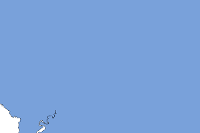

In [3]:
# Access England Boundary
england_border = gis.content.search('england1 owner:api_data_owner', 'feature layer')[1]
england_border

In [4]:
# Get the feature layer
england_boundary_layer = england_border.layers[0]


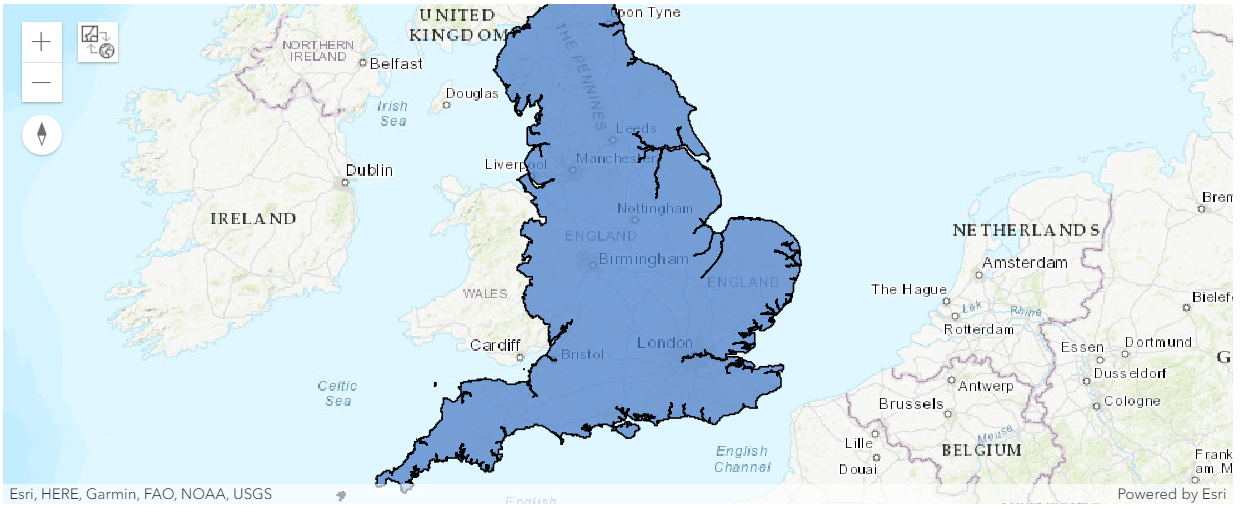

In [46]:
# Plot England boundary
england_map = gis.map('England', zoomlevel=6)
england_map.add_layer(england_boundary_layer)
england_map

### Data 2 — Weather Stations  <a class="anchor" id="6"></a>
 
There are several weather stations in England which has been recording a variety of weather data from different time periods. Here 29 weather station are strategically selected  such that they are well distributed across England and can be used to forecast temperature which will cover the entire country. These include stations located at prominent English cities such as London, Birmingham, Cardiff, Exeter, Nottingham, Plymouth and others, and are shown in the map below. 

<Item title:"england_weather_stations1" type:Feature Layer Collection owner:api_data_owner>
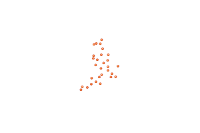

In [6]:
# Access England Weather Stations
england_weather_stations = gis.content.search('england_weather_stations1 owner:api_data_owner', 'feature layer')[0]
england_weather_stations

In [7]:
england_weather_stations_layer = england_weather_stations.layers[0]


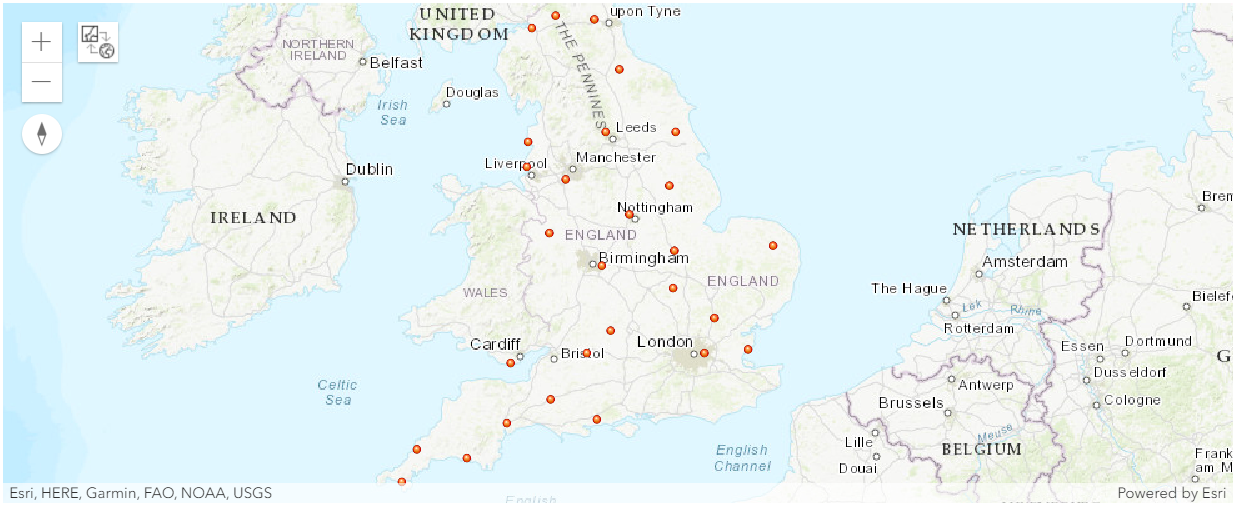

In [47]:
# England weather stations
england_weather_stations_map = gis.map('England', zoomlevel=6)
england_weather_stations_map.add_layer(england_weather_stations_layer)
england_weather_stations_map

The location of the weather stations are mapped here which are uniformly distributed throughout England. This is necessary to create a well interpolated prediction surface. The more the number of weather stations, more precise would be the interpolated result.      

In [9]:
# Access spatial dataframe
england_weather_stations_layer_sdf = pd.DataFrame.spatial.from_layer(england_weather_stations_layer)
england_weather_stations_layer_sdf.head()

FID             Station          Y         X  \
0    1           Albemarle  55.016667 -1.866667   
1    2             Begwary  52.216667 -0.483333   
2    3  Birmingham_airport  52.450000 -1.733333   
3    4   Blackpool_airport  53.766667 -3.033333   
4    5     Boulmer_airport  55.420300 -1.599700   

                                               SHAPE  
0  {'x': -207796.38285121127, 'y': 7365101.445978...  
1  {'x': -53804.420512971476, 'y': 6839396.777444...  
2  {'x': -192953.78400456344, 'y': 6881903.804921...  
3  {'x': -337669.1220358203, 'y': 7126089.0211904...  
4  {'x': -178077.78942199165, 'y': 7443868.808735...

The table above shows the latitude(Y) and longitude(X) values of the 29 weather station used in this study.  

### Data 3 —  Historic Temperature  <a class="anchor" id="7"></a>
Daily Mean temperature in degree Celsius ranging from February, 2005 till September,2019 are accessed from the above mentioned weather stations from this [website](https://rp5.ru/Weather_in_the_world) which will be the main dataset for the study. One issue with timeseries datasets that needed to be addressed was that of missing data. Thus weather stations with the least amount of missing data were selected for the study and the remaining missing data were temporally interpolated to produce the final dataset. It is as follows:

In [10]:
# Access historic temperature data of England
table = gis.content.search('all_station_date owner:api_data_owner')[0]

In [11]:
temp_history = table.tables[0]

In [12]:
# Visualize as pandas dataframe
all_station_temp_history = temp_history.query().sdf

In [13]:
all_station_temp_history.tail()

Date Albemarle Begwary Birmingham_airport Blackpool_airport  \
5350  26-09-2019     13.79   16.15              15.62             15.24   
5351  27-09-2019      10.9   13.72              13.28             13.72   
5352  28-09-2019     11.26   14.11               13.9             14.12   
5353  29-09-2019     10.68   15.25              14.79             12.68   
5354  30-09-2019      10.1   12.91              12.73              13.6   

      Boulmer_airport Bournemouth_airport  BrizeNorton_airport  \
5350              NaN               16.99                15.95   
5351              NaN               15.08                14.05   
5352              NaN               15.95                14.31   
5353              NaN               15.88                15.38   
5354              NaN               14.22                13.14   

     Cardiff_airport Carlisle  ... Nottingham Plymouth_weatherstation  \
5350           15.77     14.1  ...      14.46                   15.96   
5351           14.88    12.25  ...      12.79                   14.60   
5352           15.33    12.37  ...      13.46                   15.03   
5353           14.98     11.8  ...      13.66                   15.19   
5354           14.27    11.08  ...      12.11                   14.78   

     Rostherne Scampton_airport Shawbury_airport Southend_on_Sea_AWS  \
5350      14.9            15.21            14.65               17.16   
5351     12.77            13.05            13.37               15.76   
5352     13.67            13.36            13.91               15.68   
5353     13.19            13.49            14.14               16.18   
5354     12.12            12.08            12.02               14.31   

     Stansted_airport Wittering_airport  Yeovilton_airport ObjectId  
5350            16.27             15.85              16.64     5351  
5351            14.21             13.22              14.95     5352  
5352            14.19             14.10              15.37     5353  
5353            15.31             14.74              15.65     5354  
5354             13.5             12.56              13.70     5355  

[5 rows x 31 columns]

In [14]:
all_station_temp_history.shape

(5355, 31)

In [15]:
england_temp = all_station_temp_history[all_station_temp_history.columns[0:30]]

In [16]:
england_temp.tail()

Date Albemarle Begwary Birmingham_airport Blackpool_airport  \
5350  26-09-2019     13.79   16.15              15.62             15.24   
5351  27-09-2019      10.9   13.72              13.28             13.72   
5352  28-09-2019     11.26   14.11               13.9             14.12   
5353  29-09-2019     10.68   15.25              14.79             12.68   
5354  30-09-2019      10.1   12.91              12.73              13.6   

      Boulmer_airport Bournemouth_airport  BrizeNorton_airport  \
5350              NaN               16.99                15.95   
5351              NaN               15.08                14.05   
5352              NaN               15.95                14.31   
5353              NaN               15.88                15.38   
5354              NaN               14.22                13.14   

     Cardiff_airport Carlisle  ... Norwich_airport Nottingham  \
5350           15.77     14.1  ...            16.6      14.46   
5351           14.88    12.25  ...           13.89      12.79   
5352           15.33    12.37  ...           14.42      13.46   
5353           14.98     11.8  ...           15.46      13.66   
5354           14.27    11.08  ...           13.87      12.11   

     Plymouth_weatherstation Rostherne Scampton_airport Shawbury_airport  \
5350                   15.96      14.9            15.21            14.65   
5351                   14.60     12.77            13.05            13.37   
5352                   15.03     13.67            13.36            13.91   
5353                   15.19     13.19            13.49            14.14   
5354                   14.78     12.12            12.08            12.02   

     Southend_on_Sea_AWS Stansted_airport  Wittering_airport Yeovilton_airport  
5350               17.16            16.27              15.85             16.64  
5351               15.76            14.21              13.22             14.95  
5352               15.68            14.19              14.10             15.37  
5353               16.18            15.31              14.74             15.65  
5354               14.31             13.5              12.56             13.70  

[5 rows x 30 columns]

The table above shows the historic temperature data in degree Celsius of all the weather stations starting from 2005 to September, 2019. The first column is the Date field which is the day of the recorded temperature and rest of the columns are weather stations. 

## Transforming to Timeseries data <a class="anchor" id="8"></a>

This temperature data set is now transformed into a timeseries data format where the Date column is made into the index of the dataset. For example the daily mean temperature at Birmingham_airport on 2019-09-26 was 15.62°C  

In [17]:
# Change to datetime format
england_temp_new = england_temp.copy() 
england_temp_new[england_temp_new.columns[0]] = pd.to_datetime(england_temp_new[england_temp_new.columns[0]], format='%d-%m-%Y')
england_temp_new = england_temp_new.set_index(england_temp_new.columns[0])
england_temp_new = england_temp_new.sort_index()
all_station_temp = england_temp_new.astype('float')
all_station_temp.tail()

Albemarle  Begwary  Birmingham_airport  Blackpool_airport  \
Date                                                                    
2019-09-26      13.79    16.15               15.62              15.24   
2019-09-27      10.90    13.72               13.28              13.72   
2019-09-28      11.26    14.11               13.90              14.12   
2019-09-29      10.68    15.25               14.79              12.68   
2019-09-30      10.10    12.91               12.73              13.60   

            Boulmer_airport  Bournemouth_airport  BrizeNorton_airport  \
Date                                                                    
2019-09-26              NaN                16.99                15.95   
2019-09-27              NaN                15.08                14.05   
2019-09-28              NaN                15.95                14.31   
2019-09-29              NaN                15.88                15.38   
2019-09-30              NaN                14.22                13.14   

            Cardiff_airport  Carlisle  Crosby  ...  Norwich_airport  \
Date                                           ...                    
2019-09-26            15.77     14.10   15.45  ...            16.60   
2019-09-27            14.88     12.25   13.96  ...            13.89   
2019-09-28            15.33     12.37   14.40  ...            14.42   
2019-09-29            14.98     11.80   13.29  ...            15.46   
2019-09-30            14.27     11.08   13.82  ...            13.87   

            Nottingham  Plymouth_weatherstation  Rostherne  Scampton_airport  \
Date                                                                           
2019-09-26       14.46                    15.96      14.90             15.21   
2019-09-27       12.79                    14.60      12.77             13.05   
2019-09-28       13.46                    15.03      13.67             13.36   
2019-09-29       13.66                    15.19      13.19             13.49   
2019-09-30       12.11                    14.78      12.12             12.08   

            Shawbury_airport  Southend_on_Sea_AWS  Stansted_airport  \
Date                                                                  
2019-09-26             14.65                17.16             16.27   
2019-09-27             13.37                15.76             14.21   
2019-09-28             13.91                15.68             14.19   
2019-09-29             14.14                16.18             15.31   
2019-09-30             12.02                14.31             13.50   

            Wittering_airport  Yeovilton_airport  
Date                                              
2019-09-26              15.85              16.64  
2019-09-27              13.22              14.95  
2019-09-28              14.10              15.37  
2019-09-29              14.74              15.65  
2019-09-30              12.56              13.70  

[5 rows x 29 columns]

## Model Building <a class="anchor" id="9"></a>
Now once the dataset is transformed into a timeseries dataset it is ready to be used for modelling. In this sample two types of methodology are used for modelling: 

1) LSTM - First a deep learning framework of LSTM is used which is appropriate for handling time series data. 

2) Support Vector Machine  - In the second option the machine learning algorithm of Support Vector Regression(SVR) is used to compare the performance between the two methods in terms of accuracy and computation time.

## LSTM <a class="anchor" id="11"></a>

LSTM (Long short-term memory) first proposed by [Hochreiter & Schmidhuber](http://www.bioinf.jku.at/publications/older/2604.pdf), are a type of Recurrent Neural Network(RNN). RNN could be defined as a special kind of neural networks which can retain information from past inputs which is not possible for traditional neural networks. This makes it suitable for forecasting timeseries data wherein prediction is done based on past data. 
LSTM are built of units, each consisting of four neural network, which are used to update its cell state using information from new inputs and past outputs.

Now a function is created which encapsulates the steps for processing and predicting from the timeseries data. This consists of first accessing time series data for each station, processing them into appropriate input format and fitting a LSTM model on 90% of the data as training set. This is followed by validating the trained model on the rest 10% of the data and final forecasting for the next 31 days using the trained model. 

In [18]:
# create future forecast dates
def create_dates(start,days):
    v = pd.date_range(start=start, periods=days+1, freq='D', closed='right')
    seven_day_forecast = pd.DataFrame(index=v) 
    return seven_day_forecast

In [19]:
# get values, station name and drop null values
def get_value_name(all_station_temp,i):
    station_value = all_station_temp[[all_station_temp.columns[i]]].dropna()
    station_name = all_station_temp.columns[i]
    return station_value, station_name 

In [20]:
# train-test split of 90 to 10 ratio
def train_test_split(value,name,ratio):
    nrow = len(value)
    print(name+' total samples: ',nrow)
    split_row = int((nrow)*ratio)
    print('Training samples: ',split_row)
    print('Testing samples: ',nrow-split_row)
    train = value.iloc[:split_row]
    test = value.iloc[split_row:]
    return train, test, split_row     

In [21]:
# data transformation
def data_transformation(train_tract1,test_tract1):
    scaler = MinMaxScaler()
    train_tract1_scaled = scaler.fit_transform(train_tract1)
    test_tract1_scaled = scaler.fit_transform(test_tract1)          
    train_tract1_scaled_df = pd.DataFrame(train_tract1_scaled, index = train_tract1.index, columns=[train_tract1.columns[0]])
    test_tract1_scaled_df = pd.DataFrame(test_tract1_scaled, index = test_tract1.index, columns=[test_tract1.columns[0]])
    return train_tract1_scaled_df, test_tract1_scaled_df, scaler     

#### Feature engineering <a class="anchor" id="10"></a>

Finally one more transformation of feature engineering is required, which is to create new features using lagged values of the time series data itself. Here the number of lag terms could be specified and the function would create a new feature set using the lagged terms, having lag number of features.  

In [22]:
# feature builder - This section creates feature set with lag number of predictors--Creating features using lagged data
def timeseries_feature_builder(df, lag):
    df_copy = df.copy()
    for i in range(1,lag):
        df_copy['lag'+str(i)] = df.shift(i) 
    return df_copy
    df_copy = df.copy()

In [23]:
# preprocessing -- drop null values and make arrays 
def make_arrays(train_tract1,test_tract1):
    X_train_tract1_array = train_tract1.dropna().drop(train_tract1.columns[0], axis=1).values
    y_train_tract1_array = train_tract1.dropna()[train_tract1.columns[0]].values
    X_test_tract1_array = test_tract1.dropna().drop(test_tract1.columns[0], axis=1).values
    y_test_tract1_array = test_tract1.dropna()[test_tract1.columns[0]].values    
    return X_train_tract1_array, y_train_tract1_array, X_test_tract1_array, y_test_tract1_array

In [24]:
# Define LSTM model
def lstm_model(units, X):
    model = Sequential()
    model.add(LSTM(units,return_sequences=True, input_shape=(X.shape[1],X.shape[2]),kernel_initializer='lecun_uniform')) 
    model.add(LSTM(units, return_sequences=True))
    model.add(LSTM(units, return_sequences=True))
    model.add(LSTM(units, return_sequences=True))
    model.add(LSTM(units))
    model.add(Dropout(0.4))
    model.add(Dense(1))        
    model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
    return model

In [25]:
# model fit -- output is turned off which could be swicthed on by changing verbose=1
def lstm_fit(model, trainX, testX, y_train_tract1_array,y_test_tract1_array):
    K.clear_session()            
    history = model.fit(trainX, y_train_tract1_array, 
                        batch_size=64, epochs=100, 
                        validation_data=(testX, y_test_tract1_array), verbose=0)
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    rSquare_test = r2_score(y_test_tract1_array, testPredict)
    print('Test R-squared is: %f'%rSquare_test)    
    return testPredict, model

In [26]:
# previous lag number of data points are used to predict the next day temperature
def valid_result(scaler, testPredict, station_value, split_row, lag):
    testPredict = scaler.inverse_transform(testPredict)        
    new_test_tract1 = station_value.iloc[split_row:]       
    test_tract1_pred = new_test_tract1.iloc[lag:].copy()
    test_tract1_pred['Forecast'] = testPredict
    return test_tract1_pred 

In [27]:
# multi step future forecast for next 31 days 
def forecast(model, testX, test_tract1, lag, scaler, days):
    seven_days = []
    new0 = testX[-1]        
    last = test_tract1.iloc[-1]
    new_predict = last[0]        
    new_array = np.insert(new0, 0, new_predict)        
    new_array = np.delete(new_array, -1)
    new_array_reshape = np.reshape(new_array, (-1,1,lag))       
    new_predict = model.predict(new_array_reshape)
    temp_predict = scaler.inverse_transform(new_predict) 
    seven_days.append(temp_predict[0][0].round(2))
    
    for i in range(1,days):
        new_array = np.insert(new_array, 0, new_predict)             
        new_array = np.delete(new_array, -1)
        new_array_reshape = np.reshape(new_array, (-1,1,lag))            
        new_predict = model.predict(new_array_reshape)
        temp_predict = scaler.inverse_transform(new_predict) 
        seven_days.append(temp_predict[0][0].round(2))
    return seven_days         

Now the main function is created which uses the above modules for predicting the monthly forecast

In [28]:
def england_temp_lstm(all_station_temp, lag, days):    
    
    seven_day_forecast_lstm = create_dates('2019-09-30',days) 
    
    for i in range(len(all_station_temp.columns)):
        
        # preprocessing
        station_value, station_name = get_value_name(all_station_temp,i)        
        train_tract1, test_tract1, split_row = train_test_split(station_value, station_name, 0.90)        
        train_tract1_scaled_df, test_tract1_scaled_df, scaler = data_transformation(train_tract1,test_tract1) 
        train_tract1 = timeseries_feature_builder(train_tract1_scaled_df, lag+1) 
        test_tract1 = timeseries_feature_builder(test_tract1_scaled_df, lag+1)               
        X_train_tract1_array, y_train_tract1_array, X_test_tract1_array, y_test_tract1_array = make_arrays(train_tract1, 
                                                                                                           test_tract1)        
        trainX = np.reshape(X_train_tract1_array, (X_train_tract1_array.shape[0],1,X_train_tract1_array.shape[1]))
        testX = np.reshape(X_test_tract1_array, (X_test_tract1_array.shape[0],1,X_test_tract1_array.shape[1]))                
        
        # LSTM modelling & forecast
        model = lstm_model(30, trainX)         
        testPredict, model = lstm_fit(model, trainX, testX, y_train_tract1_array,y_test_tract1_array)        
        test_tract1_pred = valid_result(scaler, testPredict, station_value, split_row, lag)        
        seven_days = forecast(model, testX, test_tract1, lag, scaler, days)       
        seven_day_forecast_lstm[station_name] = np.array(seven_days)       
        
        # plot result
        plt.figure(figsize=(20,5))
        plt.plot(test_tract1_pred)        
        plt.plot(seven_day_forecast_lstm[station_name], color='red', label='forecast')         
        plt.ylabel('Temperature(°C)')
        plt.legend(loc='upper right')
        plt.title(station_name + '- October 2019 Temperature Forecast')
        plt.show()        
        
    return(seven_day_forecast_lstm)

In summary this function first trains a LSTM model on 90% of temperature data for a station and validates on the rest 10%, followed by future prediction for the stations for the next 31 days using the fitted model and past lag data. This operation is then repeated for all the 29 weather stations which returns a final table of daily temperature forecast for all 29 stations.         

Now the above function is called on the weather station dataset consisting of past temperature data from the selected weather stations. It is given three input: the data table, number of past day's data to be used for forecasting and the number of days for which the temperature is to be predicted.

Albemarle total samples:  3648
Training samples:  3283
Testing samples:  365
Test R-squared is: 0.868426


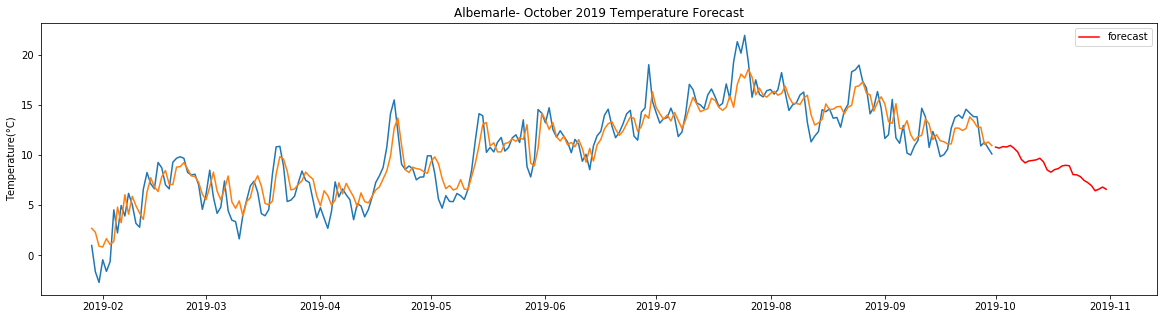

Begwary total samples:  3648
Training samples:  3283
Testing samples:  365
Test R-squared is: 0.867620


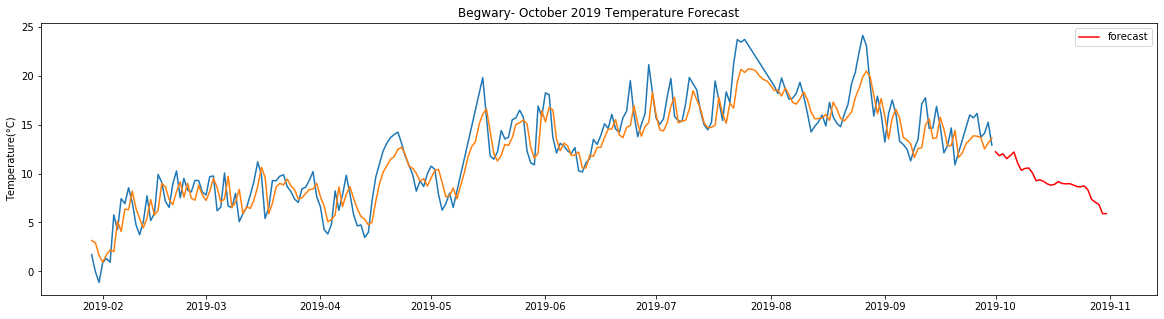

Birmingham_airport total samples:  2556
Training samples:  2300
Testing samples:  256
Test R-squared is: 0.541439


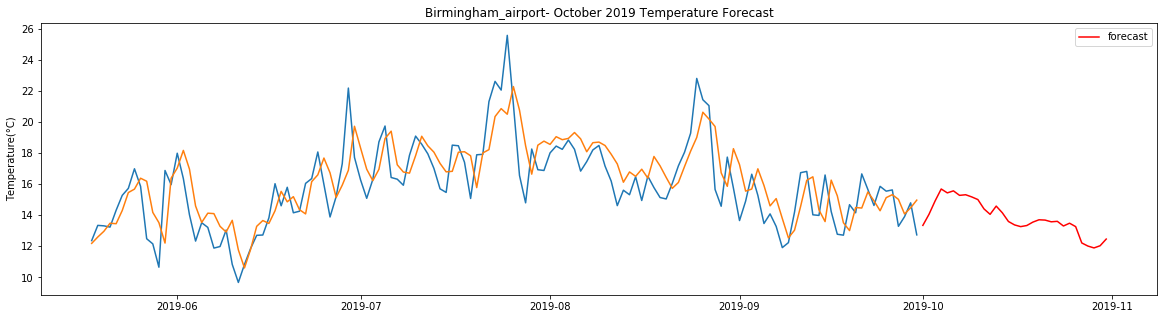

Blackpool_airport total samples:  3501
Training samples:  3150
Testing samples:  351
Test R-squared is: 0.877703


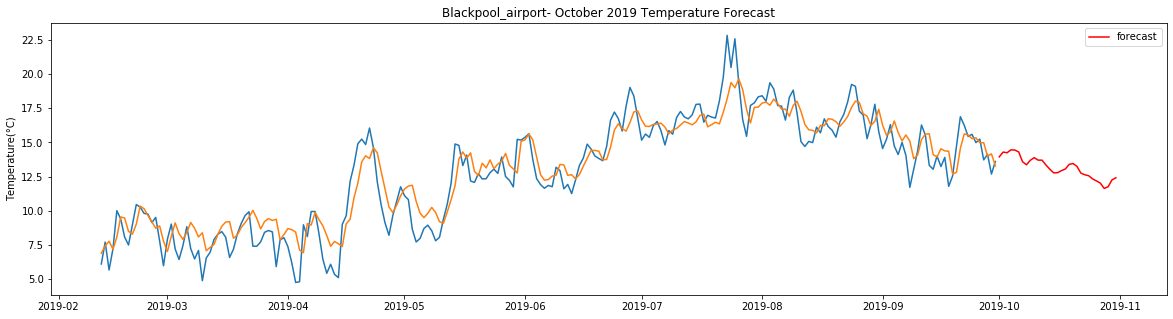

Boulmer_airport total samples:  5302
Training samples:  4771
Testing samples:  531
Test R-squared is: 0.816715


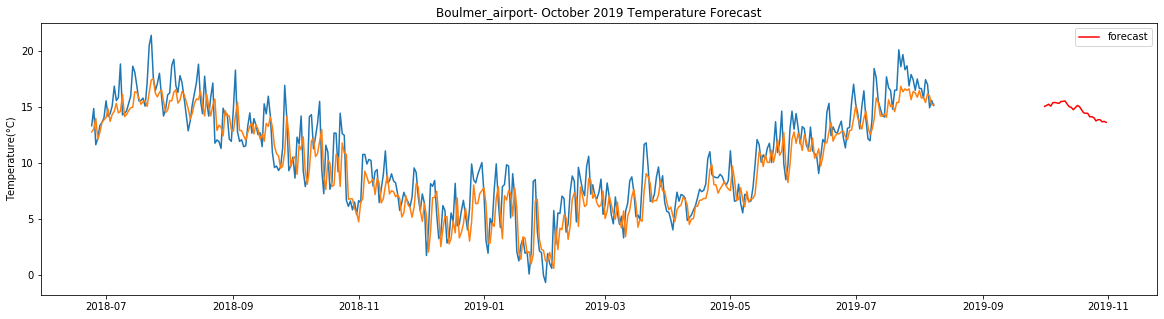

Bournemouth_airport total samples:  3648
Training samples:  3283
Testing samples:  365
Test R-squared is: 0.870947


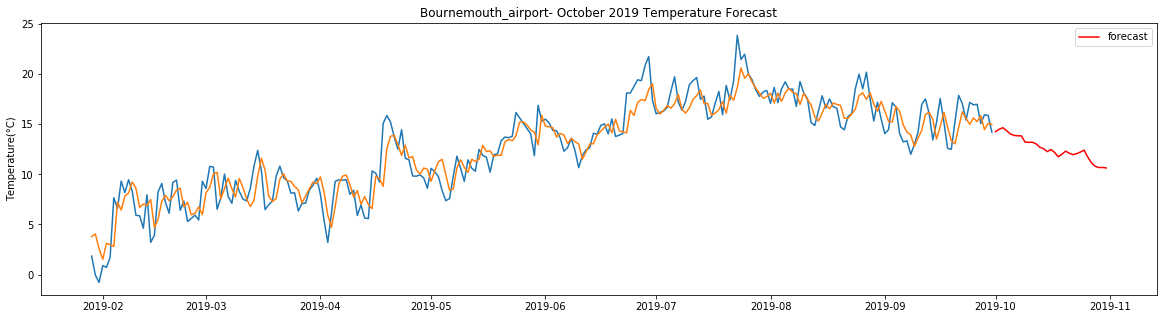

BrizeNorton_airport total samples:  5355
Training samples:  4819
Testing samples:  536
Test R-squared is: 0.849079


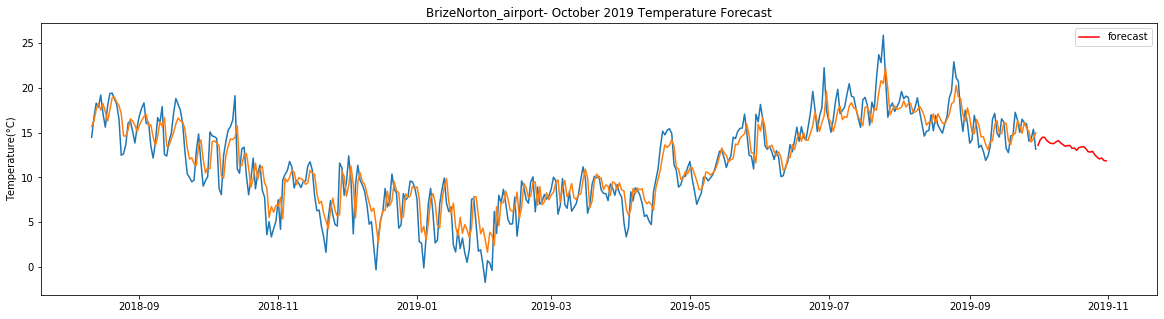

Cardiff_airport total samples:  2556
Training samples:  2300
Testing samples:  256
Test R-squared is: 0.601139


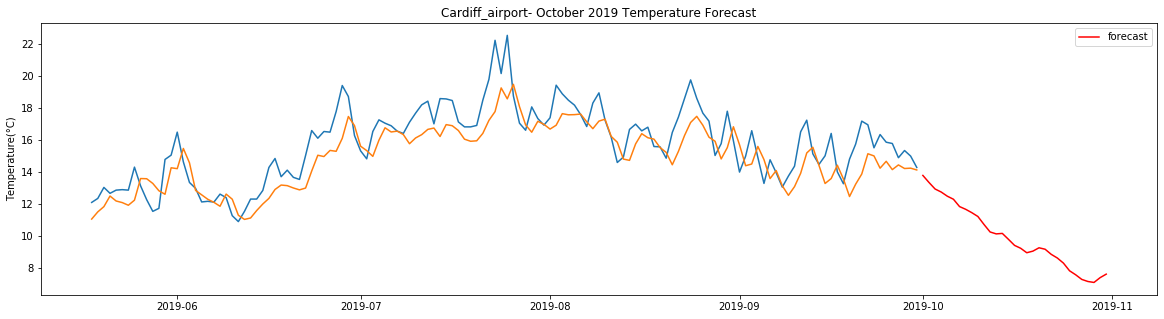

Carlisle total samples:  3529
Training samples:  3176
Testing samples:  353
Test R-squared is: 0.835846


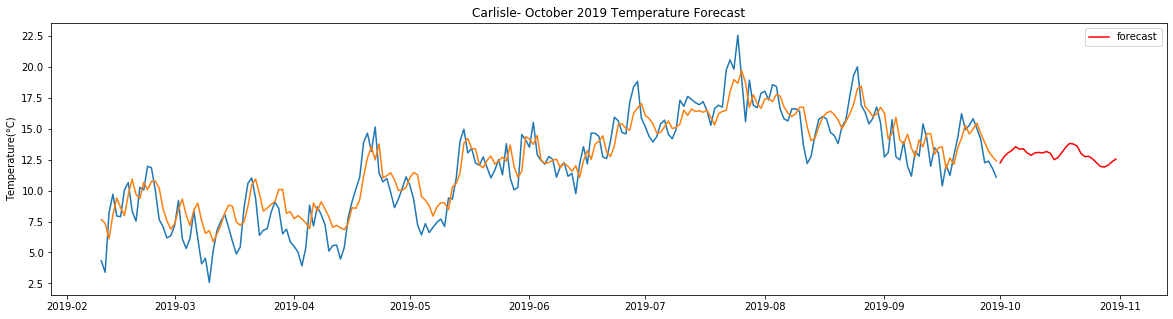

Crosby total samples:  3648
Training samples:  3283
Testing samples:  365
Test R-squared is: 0.877153


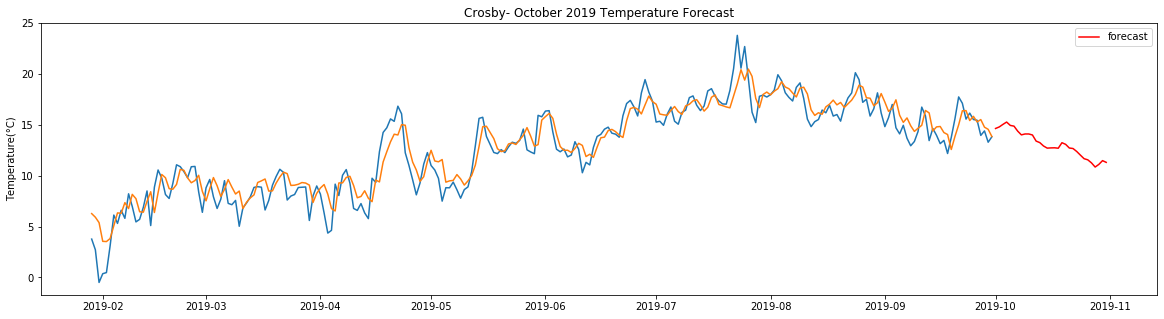

Culdrose_airport total samples:  2556
Training samples:  2300
Testing samples:  256
Test R-squared is: 0.728223


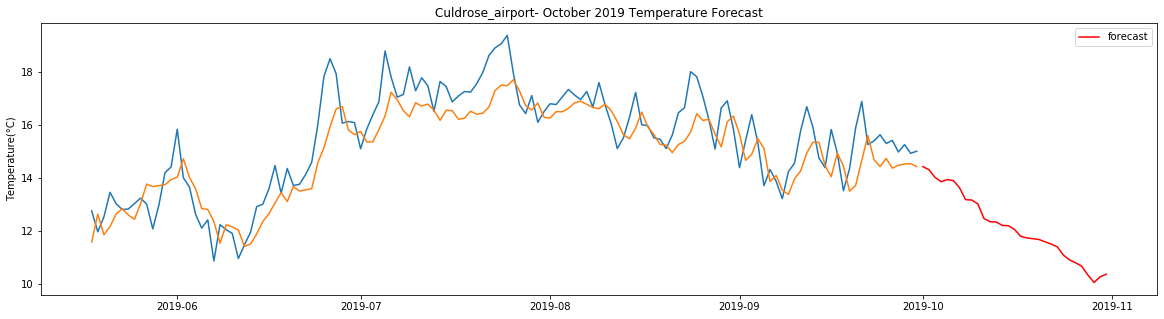

DurhamTeesValley_airport total samples:  2556
Training samples:  2300
Testing samples:  256
Test R-squared is: 0.588892


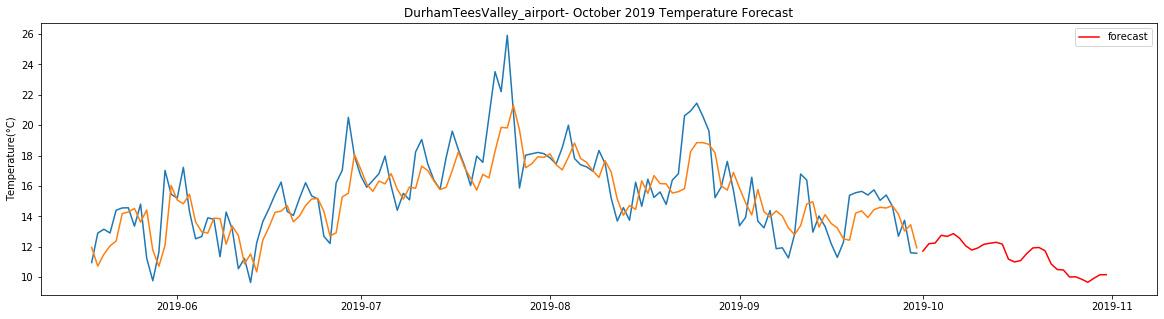

Exeter_airport total samples:  2556
Training samples:  2300
Testing samples:  256
Test R-squared is: 0.431207


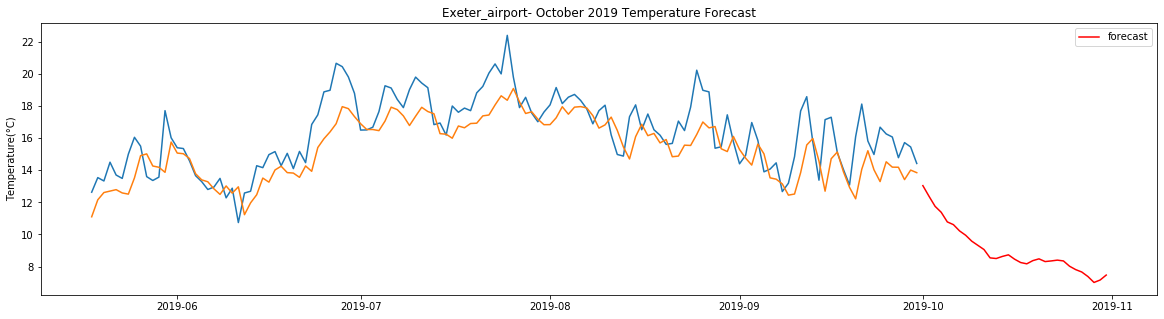

Leconfield_airport total samples:  2555
Training samples:  2299
Testing samples:  256
Test R-squared is: 0.395065


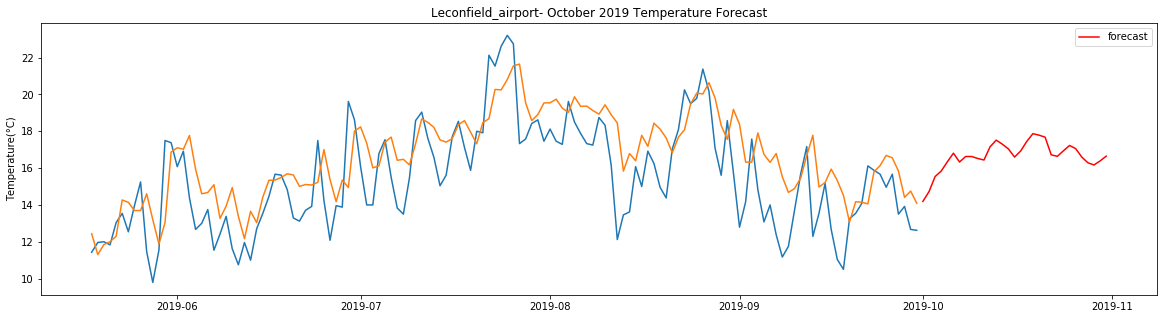

SpadeadamKingwater_airport total samples:  2556
Training samples:  2300
Testing samples:  256
Test R-squared is: 0.588437


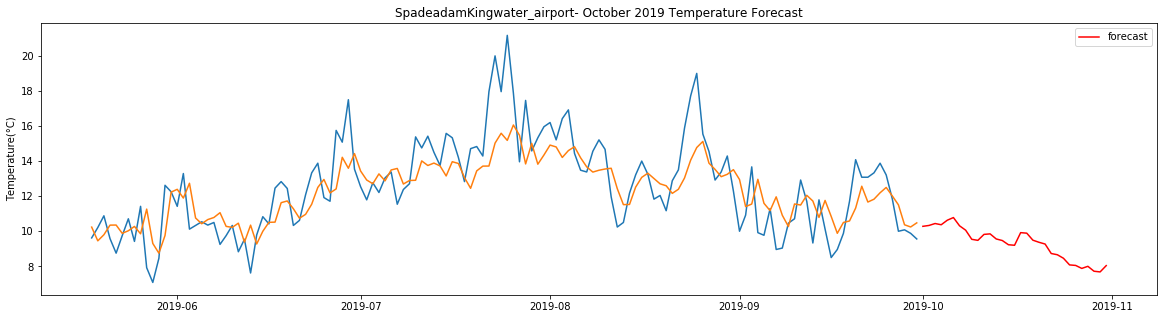

LeedsBradford_airport total samples:  2922
Training samples:  2629
Testing samples:  293
Test R-squared is: 0.758670


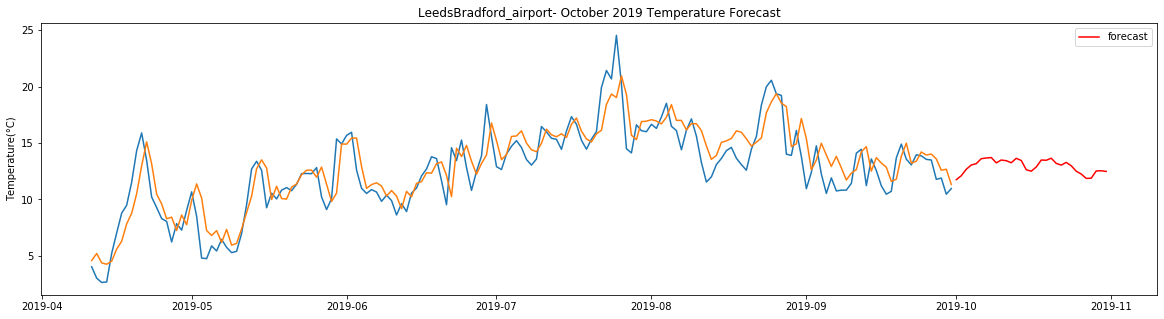

LondonCity_airport total samples:  2556
Training samples:  2300
Testing samples:  256
Test R-squared is: 0.232157


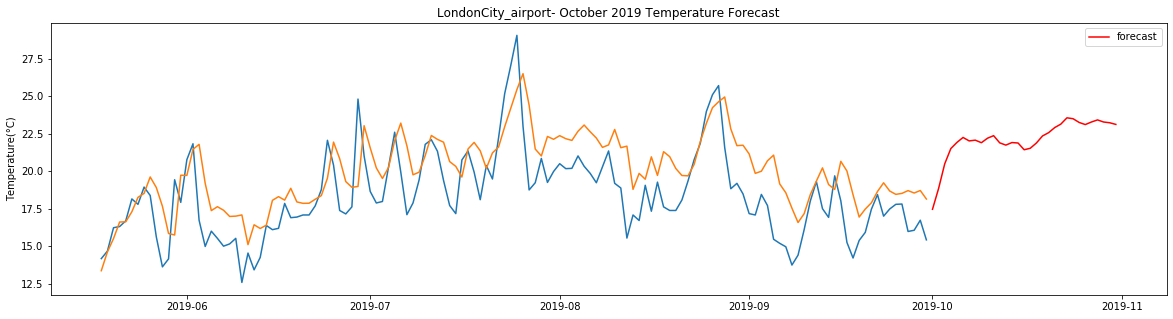

Lyneham_airport total samples:  5355
Training samples:  4819
Testing samples:  536
Test R-squared is: 0.855236


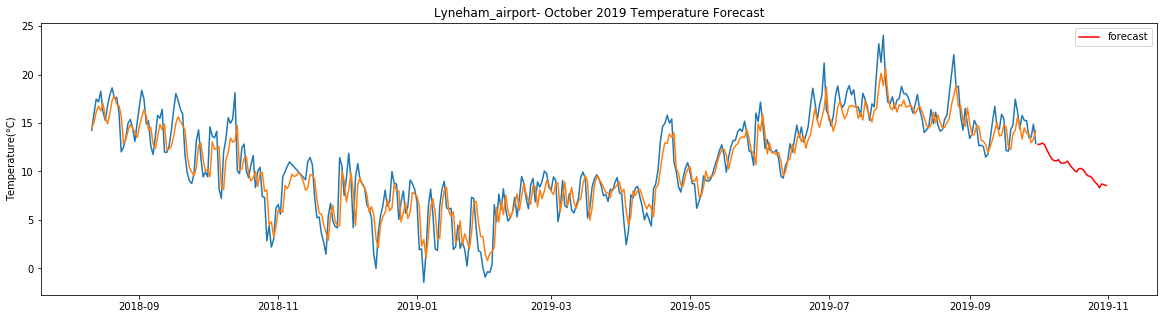

NewquayCornwall_airport total samples:  2556
Training samples:  2300
Testing samples:  256
Test R-squared is: 0.651072


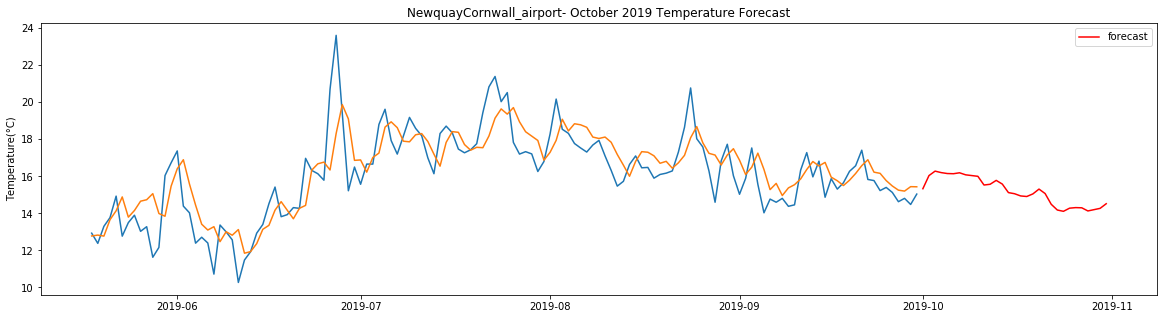

Norwich_airport total samples:  2556
Training samples:  2300
Testing samples:  256
Test R-squared is: 0.510049


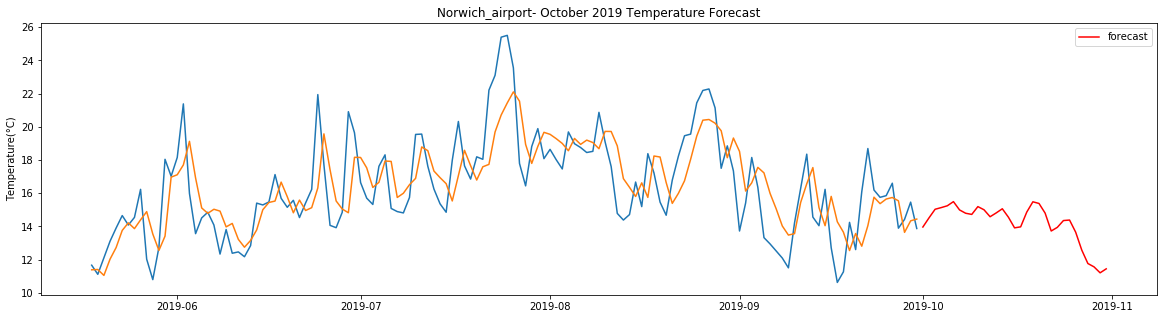

Nottingham total samples:  5355
Training samples:  4819
Testing samples:  536
Test R-squared is: 0.826039


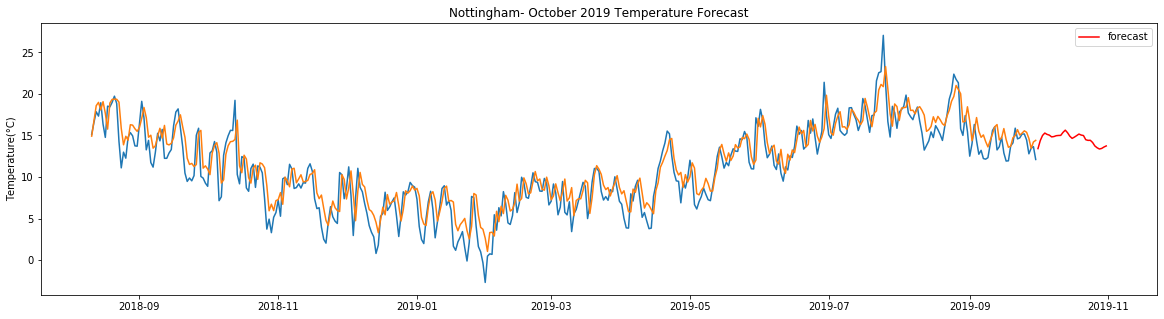

Plymouth_weatherstation total samples:  5355
Training samples:  4819
Testing samples:  536
Test R-squared is: 0.861601


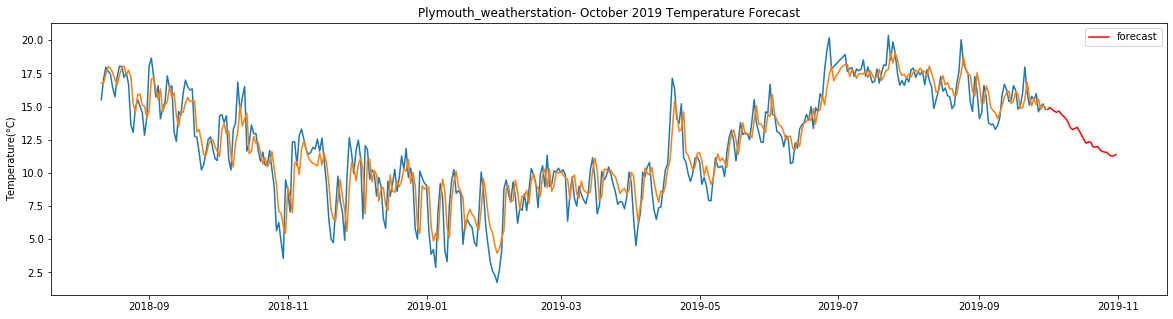

Rostherne total samples:  2495
Training samples:  2245
Testing samples:  250
Test R-squared is: 0.614020


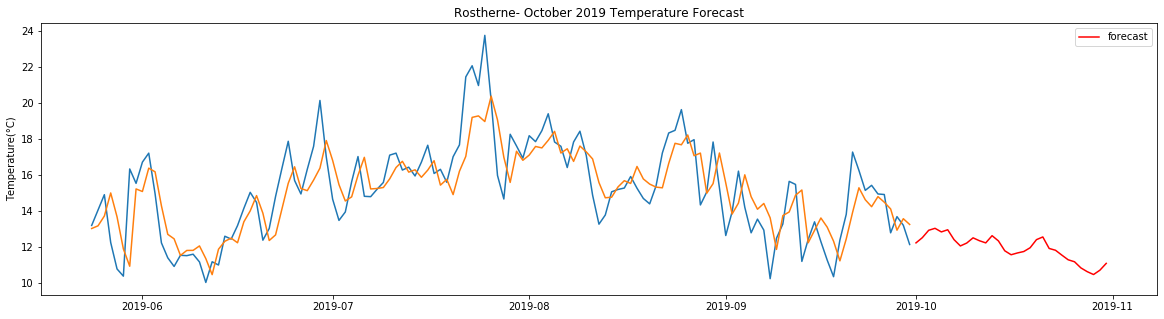

Scampton_airport total samples:  3543
Training samples:  3188
Testing samples:  355
Test R-squared is: 0.807643


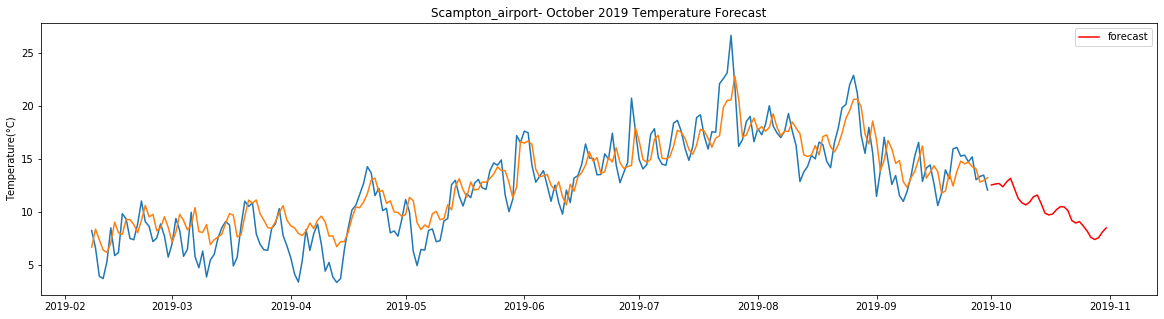

Shawbury_airport total samples:  5355
Training samples:  4819
Testing samples:  536
Test R-squared is: 0.780633


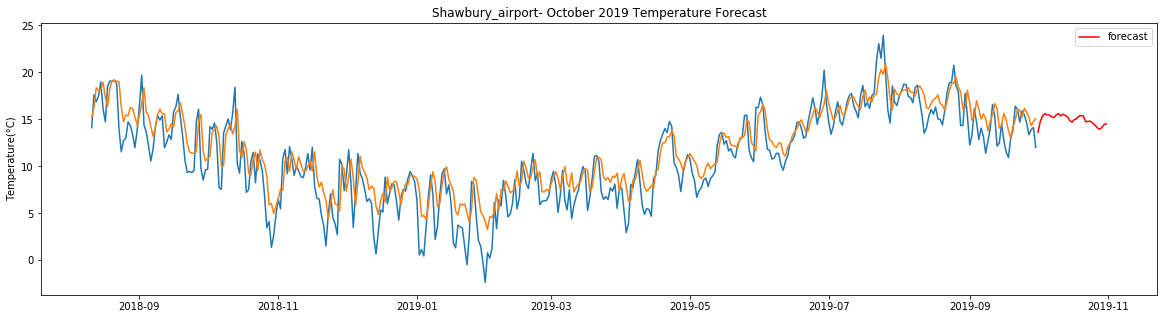

Southend_on_Sea_AWS total samples:  3648
Training samples:  3283
Testing samples:  365
Test R-squared is: 0.888980


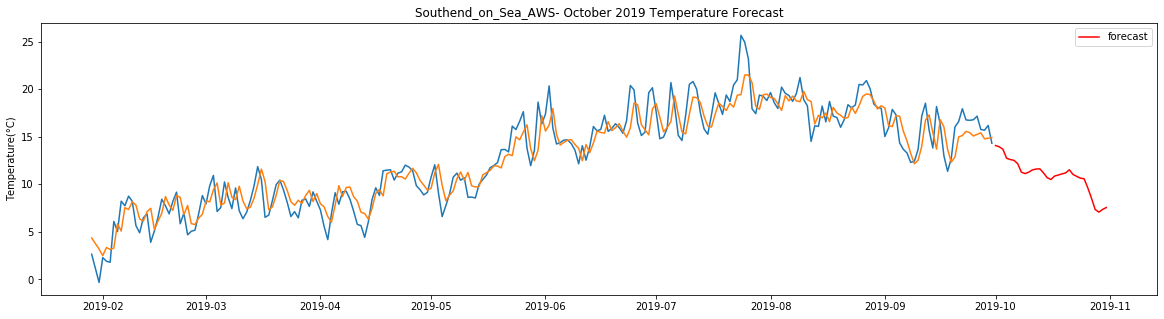

Stansted_airport total samples:  2556
Training samples:  2300
Testing samples:  256
Test R-squared is: 0.494070


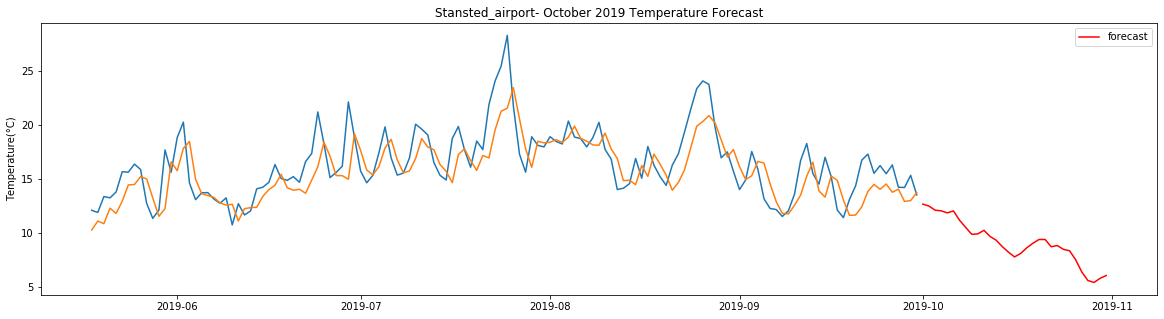

Wittering_airport total samples:  5355
Training samples:  4819
Testing samples:  536
Test R-squared is: 0.846726


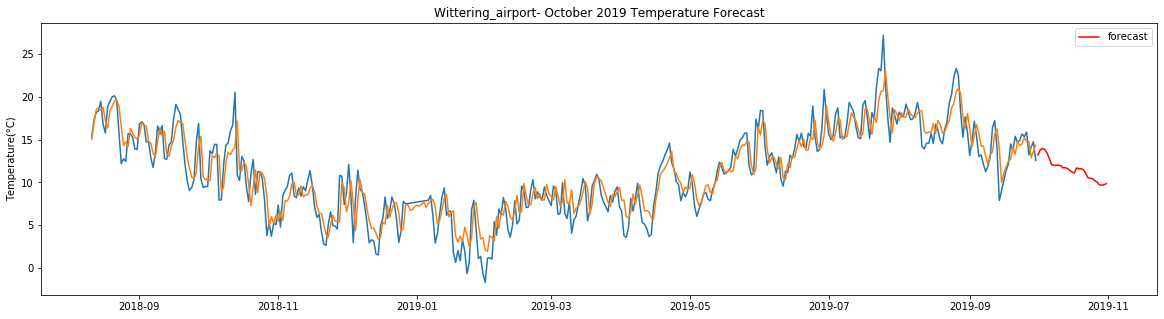

Yeovilton_airport total samples:  5355
Training samples:  4819
Testing samples:  536
Test R-squared is: 0.800435


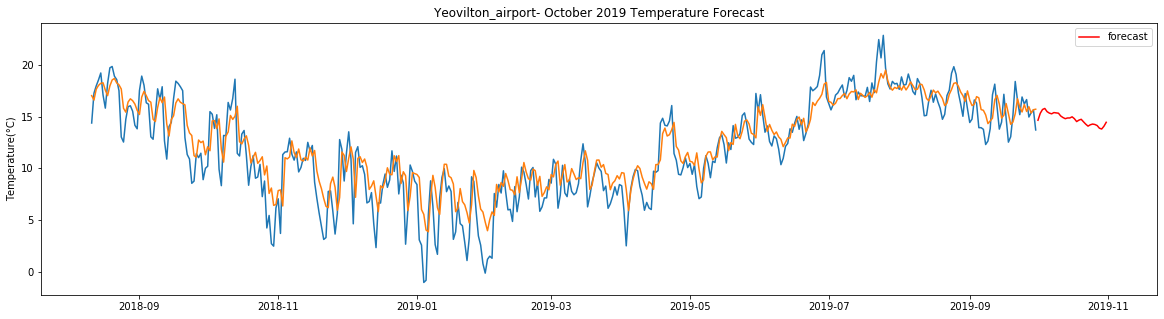

Wall time: 44min 3s


In [49]:
%%time
# Fitting and forecast using LSTM 
# In the above the output of train loss and valid loss during model fitting is turned off
lstm_prediction = england_temp_lstm(all_station_temp,120,31)

The result above gives model metrics of the fitted data for each weather station followed by visualization of the output and the monthly forecast, with past observed temperatures in Blue, validation in Orange and forecast in Red. It can be seen that the data are fitted reasonably with high accuracy for most of the stations. 

### Temperature forecasted by LSTM model <a class="anchor" id="12"></a>

The output forecasted temperature for the weather stations by the model is as follows:   

In [30]:
# 30 days of forecast for October,2019 obtained from the LSTM model for each weather stations
lstm_prediction.head()

Albemarle  Begwary  Birmingham_airport  Blackpool_airport  \
2019-10-01      11.15    12.62               12.25              13.78   
2019-10-02      11.48    12.57               12.61              13.90   
2019-10-03      11.66    13.07               13.33              14.14   
2019-10-04      11.90    12.89               13.19              14.33   
2019-10-05      12.11    13.38               12.71              14.23   

            Boulmer_airport  Bournemouth_airport  BrizeNorton_airport  \
2019-10-01        15.460000                14.82                13.48   
2019-10-02        16.000000                15.45                13.88   
2019-10-03        16.110001                15.65                14.02   
2019-10-04        16.070000                15.34                13.85   
2019-10-05        16.299999                15.32                13.48   

            Cardiff_airport  Carlisle     Crosby  ...  Norwich_airport  \
2019-10-01            14.16     12.27  15.000000  ...            13.50   
2019-10-02            14.14     12.68  15.710000  ...            14.41   
2019-10-03            14.22     13.19  16.080000  ...            14.75   
2019-10-04            13.96     13.76  16.559999  ...            14.72   
2019-10-05            13.65     14.16  16.590000  ...            15.25   

            Nottingham  Plymouth_weatherstation  Rostherne  Scampton_airport  \
2019-10-01       13.70                    15.05      12.85             13.54   
2019-10-02       14.74                    15.40      13.50             14.47   
2019-10-03       15.40                    15.49      14.20             14.99   
2019-10-04       15.77                    15.34      14.40             15.05   
2019-10-05       15.79                    15.29      14.39             15.83   

            Shawbury_airport  Southend_on_Sea_AWS  Stansted_airport  \
2019-10-01             13.65                14.42             12.62   
2019-10-02             14.65                14.32             12.22   
2019-10-03             15.21                14.00             11.93   
2019-10-04             15.42                13.34             11.10   
2019-10-05             15.39                13.23             10.63   

            Wittering_airport  Yeovilton_airport  
2019-10-01              13.54              13.76  
2019-10-02              14.33              13.90  
2019-10-03              14.50              13.92  
2019-10-04              14.35              13.94  
2019-10-05              13.95              13.41  

[5 rows x 29 columns]

The table above gives the daily forecast for the month of October for each of the 29 location using LSTM. The columns indicate the location of the weather stations and the rows are the forecasted temperature in degeree celsius for each day of the month starting from 2019-10-01. 

## Support Vector Machine <a class="anchor" id="13"></a>

Support Vector Machine was first proposed by Vladimir Vapnik as a binary linear classifier in 1963 which was further developed in 1992 to a non linear classifier. This algorithm classifies data by creating hyperplanes between different classes using the maximal margin method. The maximum margin represented as epsilon(ε) is the maximum separation distance(2ε) that can be achieved between the nearest data points of the two classes. These data points which are critical for the hyperplane are known as support vectors. 

This study being a regression problem, here its regression variant also known as [Support Vector Regression(SVR)](https://papers.nips.cc/paper/1238-support-vector-regression-machines.pdf) is used, which was proposed in 1996 by Vapnik .et.al, suitable for regression in high dimensionality space. The algorithm uses the same maximal margin principle but instead of separating classes it creates a tube with a radius of epsilon(ε) to include the data points. The primary parameters for SVR are the kernel function and its coefficient required to map the data points to a higher dimension space, epsilon(ε) or tube radius, and C or cost as penalty.          

In the second method this machine learning algorithm of Support Vector Regression(SVR) is applied to compare performances by the deep learning framework, since it is suitable for fitting high dimensional data with comparatively fewer samples. Accordingly a function is first created which would first receive the time series data, followed by fitting it using the ML model and forecasting daily for the month of October, 2019. 

In [31]:
# fitting & Validating using SVR
def fit_svr(X_train_tract1_array, y_train_tract1_array, X_test_tract1_array, y_test_tract1_array):
    model_svr = SVR(kernel='rbf', gamma='auto', tol=0.001, C=10.0, epsilon=0.001)
    model_svr.fit(X_train_tract1_array,y_train_tract1_array)
    y_pred_train_tract1 = model_svr.predict(X_train_tract1_array)
    y_pred_test_tract1 = model_svr.predict(X_test_tract1_array)        
    print('r-square_SVR_Test: ', round(model_svr.score(X_test_tract1_array,y_test_tract1_array),2))
    return model_svr, y_pred_test_tract1   

In [32]:
# validation result  
def valid_result_svr(scaler, y_pred_test_tract1, station_value, split_row, lag):
    new_test_tract1 = station_value.iloc[split_row:]
    test_tract1_pred = new_test_tract1.iloc[lag:].copy()
    y_pred_test_tract1_transformed = scaler.inverse_transform([y_pred_test_tract1])
    y_pred_test_tract1_transformed_reshaped = np.reshape(y_pred_test_tract1_transformed,(y_pred_test_tract1_transformed.shape[1],-1))
    test_tract1_pred['Forecast'] = np.array(y_pred_test_tract1_transformed_reshaped)
    return test_tract1_pred

In [33]:
# multi-step future forecast
def forecast_svr(X_test_tract1_array, days ,model_svr, lag, scaler):
    last_test_sample = X_test_tract1_array[-1]        
    X_last_test_sample = np.reshape(last_test_sample,(-1,X_test_tract1_array.shape[1]))        
    y_pred_last_sample = model_svr.predict(X_last_test_sample)                
    new_array = X_last_test_sample
    new_predict = y_pred_last_sample
    new_array = X_last_test_sample
    new_predict = y_pred_last_sample

    seven_days_svr=[]
    for i in range(0,days):               
            new_array = np.insert(new_array, 0, new_predict)                
            new_array = np.delete(new_array, -1)
            new_array_reshape = np.reshape(new_array, (-1,lag))                
            new_predict = model_svr.predict(new_array_reshape)
            temp_predict = scaler.inverse_transform([new_predict])
            seven_days_svr.append(temp_predict[0][0].round(2))
            
    return seven_days_svr 

Now the main function is created for estimating the monthly forecast 

In [34]:
def england_temp_svr(all_station_temp, lag, days):     
    
    seven_day_forecast_svr = create_dates('2019-09-30',days)
    
    for i in range(len(all_station_temp.columns)):
        
        # preprocessing
        station_value, station_name = get_value_name(all_station_temp,i)       
        train_tract1, test_tract1, split_row = train_test_split(station_value, station_name, 0.80)              
        train_tract1_scaled_df, test_tract1_scaled_df, scaler = data_transformation(train_tract1,test_tract1)        
        train_tract1 = timeseries_feature_builder(train_tract1_scaled_df,lag+1)
        test_tract1 = timeseries_feature_builder(test_tract1_scaled_df, lag+1)        
        X_train_tract1_array, y_train_tract1_array, X_test_tract1_array, y_test_tract1_array = make_arrays(train_tract1,
                                                                                                           test_tract1)

        # SVR modeling
        model_svr, y_pred_test_tract1 = fit_svr(X_train_tract1_array, y_train_tract1_array,
                                                X_test_tract1_array, y_test_tract1_array)                       
        test_tract1_pred = valid_result_svr(scaler, y_pred_test_tract1, station_value, split_row, lag)        
        seven_days_svr = forecast_svr(X_test_tract1_array, days, model_svr, lag, scaler)            
        seven_day_forecast_svr[station_name] = np.array(seven_days_svr)        
        
        # plot result
        plt.figure(figsize=(20,5))
        plt.plot(test_tract1_pred)
        plt.plot(seven_day_forecast_svr[station_name], color='red', label='forecast') 
        plt.ylabel('Temperature(°C)')
        plt.legend(loc='upper right')
        plt.title(station_name + '- October 2019 Temperature Forecast')
        plt.show()    
        
    return(seven_day_forecast_svr)

The function is now called on the same temperature dataset and outputs are recorded. It is given three input: first the historic temperature dataset, the number of lagged terms to be used for prediction and finally the number of days of forecasting.   

Albemarle total samples:  3648
Training samples:  2918
Testing samples:  730
r-square_SVR_Test:  0.82


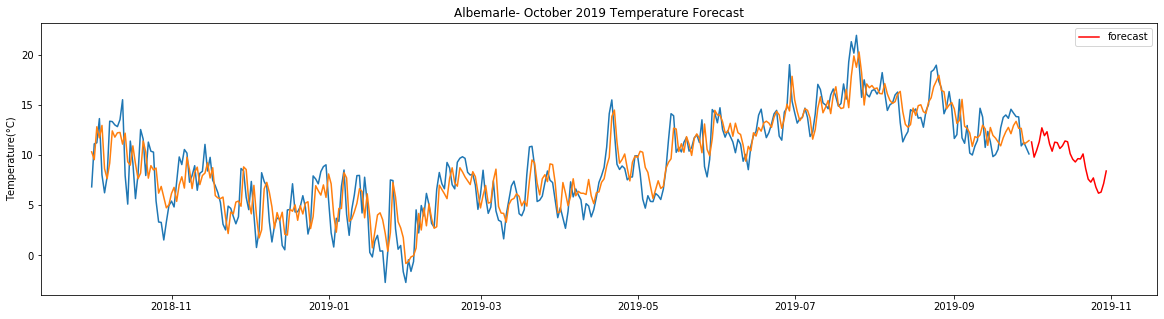

Begwary total samples:  3648
Training samples:  2918
Testing samples:  730
r-square_SVR_Test:  0.84


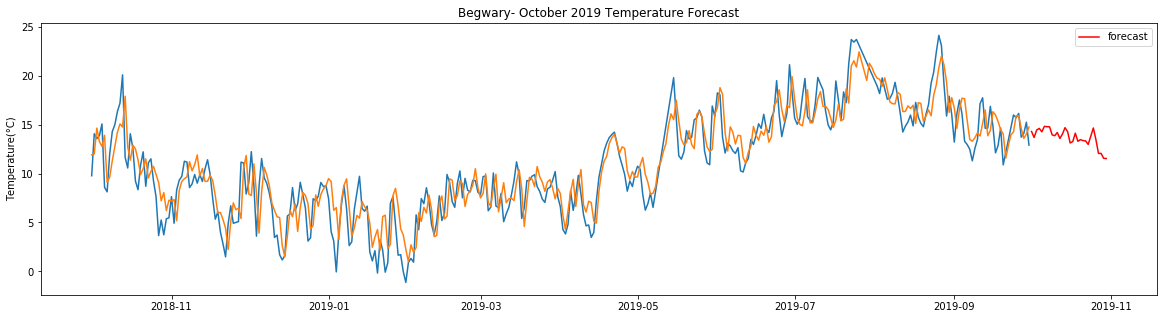

Birmingham_airport total samples:  2556
Training samples:  2044
Testing samples:  512
r-square_SVR_Test:  0.51


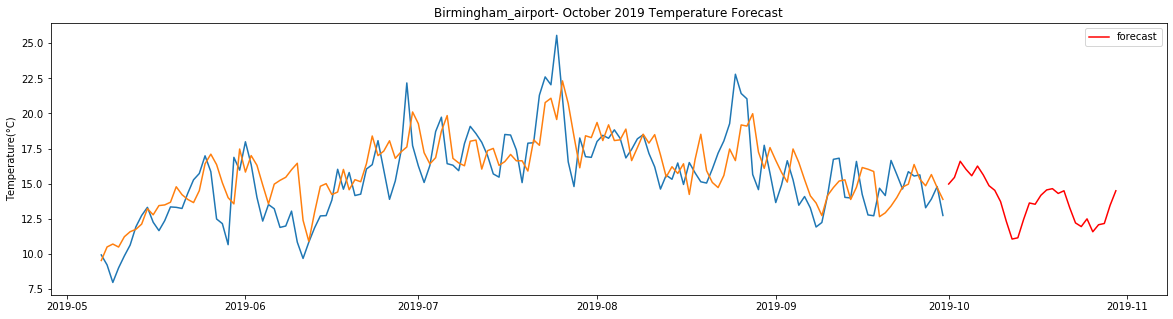

Blackpool_airport total samples:  3501
Training samples:  2800
Testing samples:  701
r-square_SVR_Test:  0.87


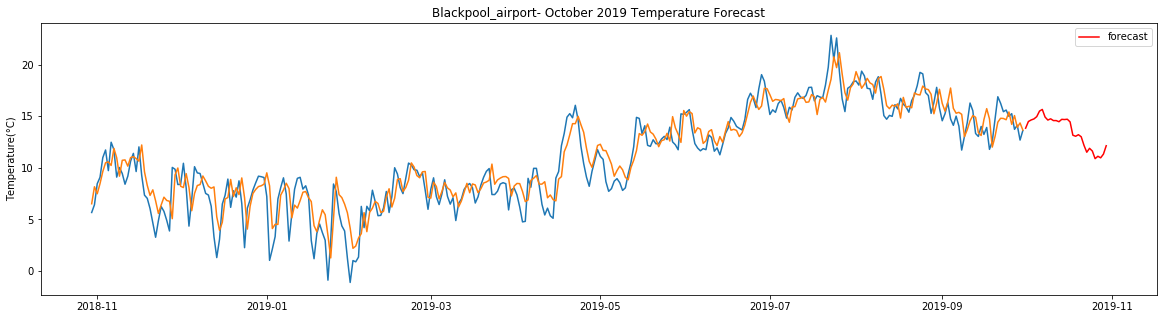

Boulmer_airport total samples:  5302
Training samples:  4241
Testing samples:  1061
r-square_SVR_Test:  0.83


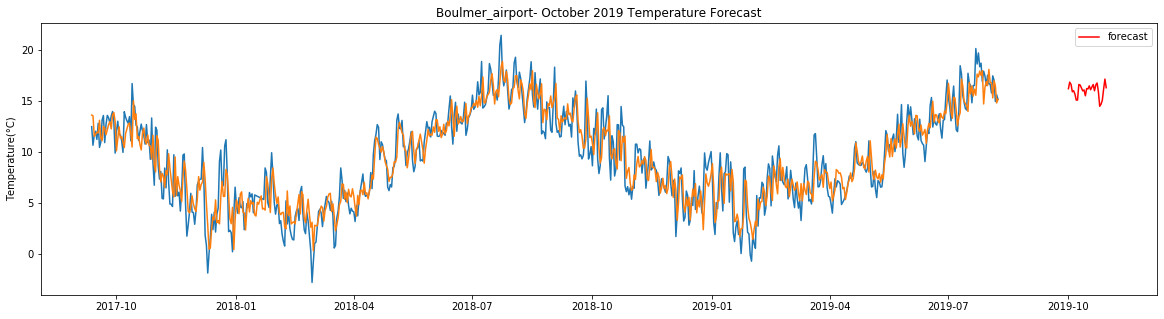

Bournemouth_airport total samples:  3648
Training samples:  2918
Testing samples:  730
r-square_SVR_Test:  0.8


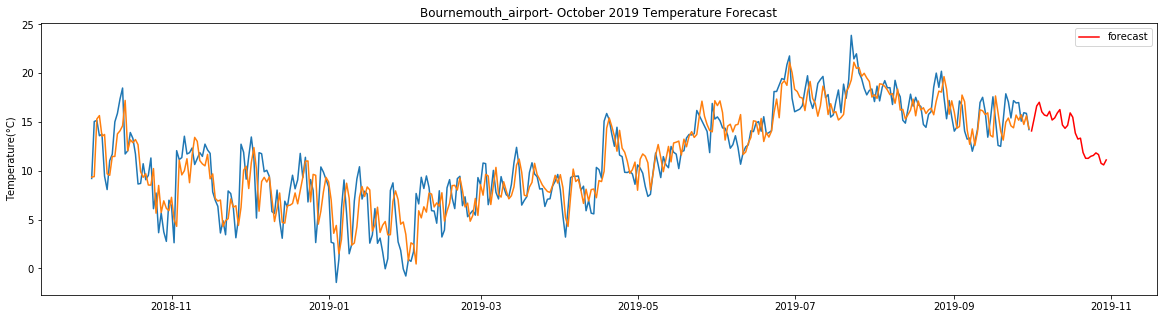

BrizeNorton_airport total samples:  5355
Training samples:  4284
Testing samples:  1071
r-square_SVR_Test:  0.87


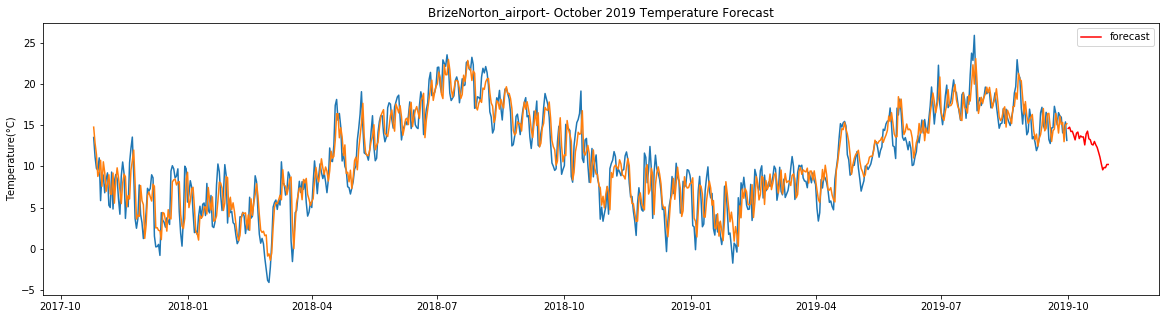

Cardiff_airport total samples:  2556
Training samples:  2044
Testing samples:  512
r-square_SVR_Test:  0.61


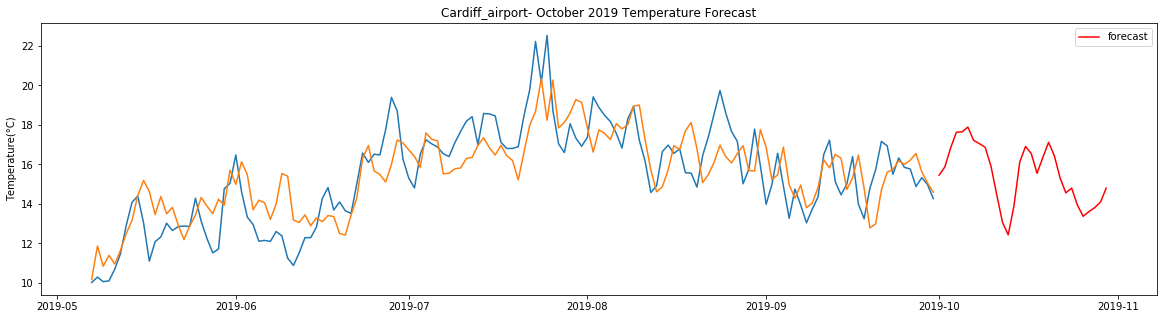

Carlisle total samples:  3529
Training samples:  2823
Testing samples:  706
r-square_SVR_Test:  0.8


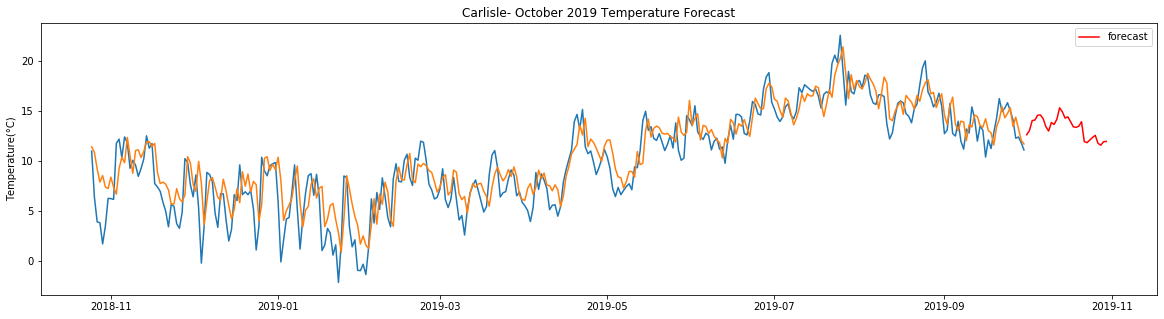

Crosby total samples:  3648
Training samples:  2918
Testing samples:  730
r-square_SVR_Test:  0.85


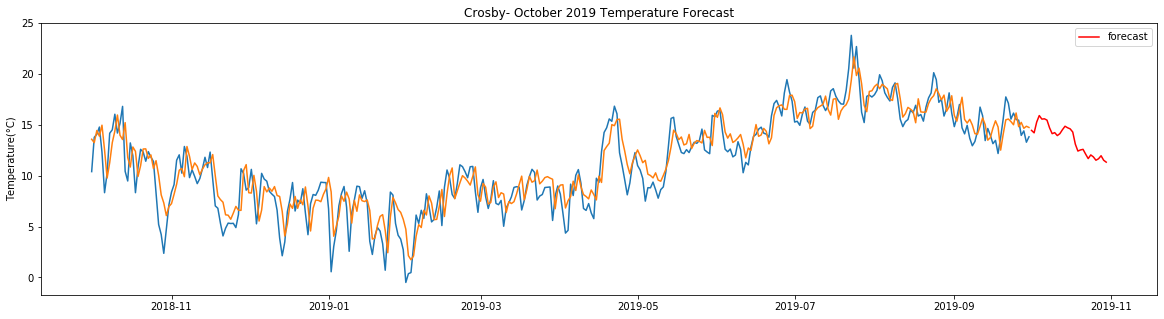

Culdrose_airport total samples:  2556
Training samples:  2044
Testing samples:  512
r-square_SVR_Test:  0.76


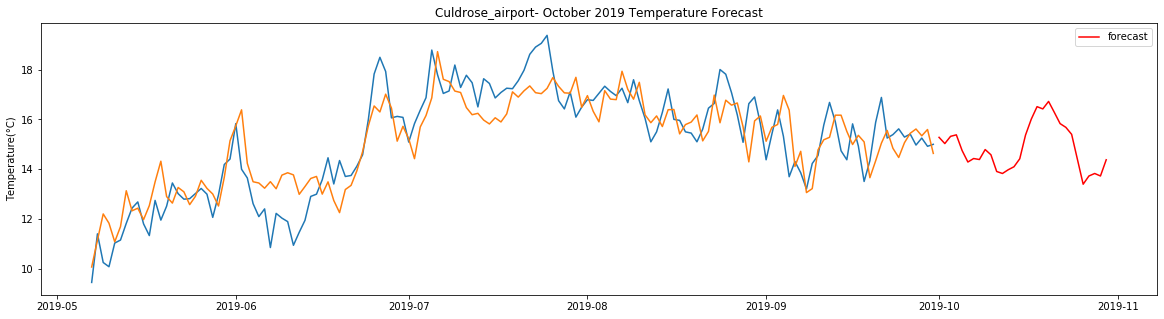

DurhamTeesValley_airport total samples:  2556
Training samples:  2044
Testing samples:  512
r-square_SVR_Test:  0.61


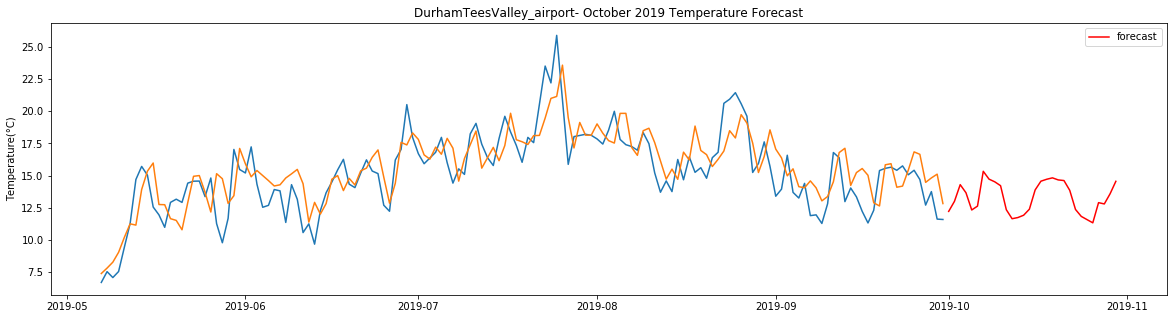

Exeter_airport total samples:  2556
Training samples:  2044
Testing samples:  512
r-square_SVR_Test:  0.5


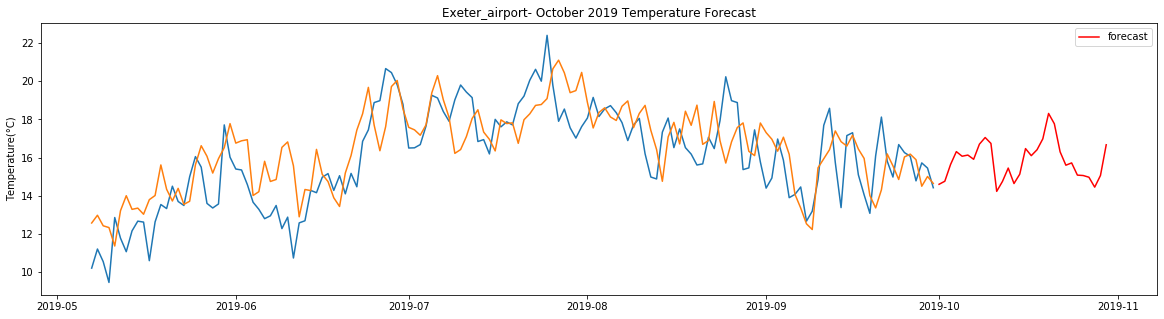

Leconfield_airport total samples:  2555
Training samples:  2044
Testing samples:  511
r-square_SVR_Test:  0.51


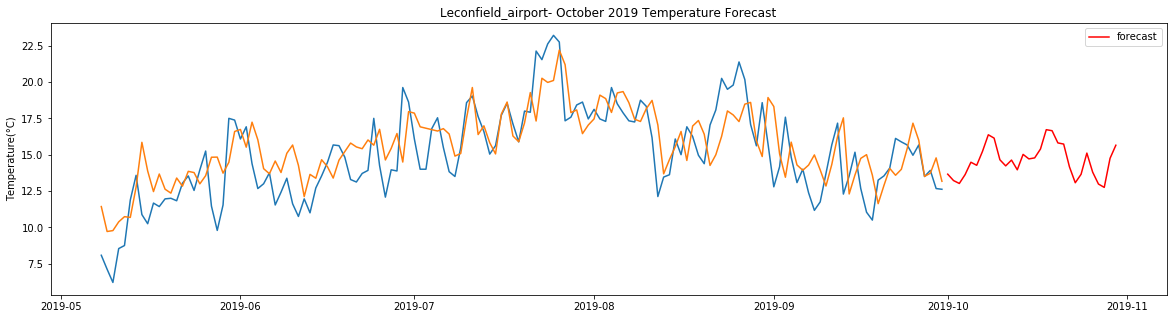

SpadeadamKingwater_airport total samples:  2556
Training samples:  2044
Testing samples:  512
r-square_SVR_Test:  0.62


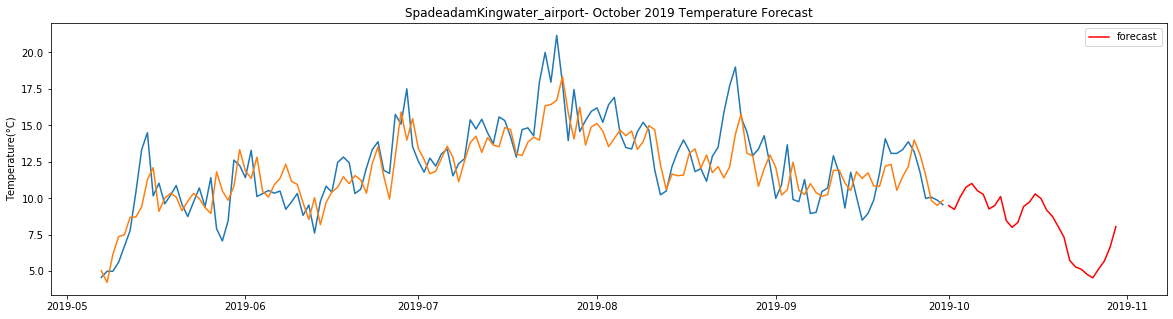

LeedsBradford_airport total samples:  2922
Training samples:  2337
Testing samples:  585
r-square_SVR_Test:  0.79


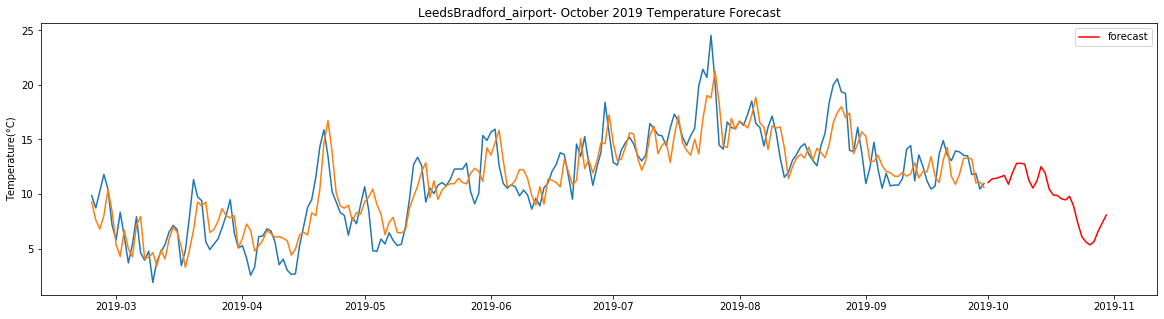

LondonCity_airport total samples:  2556
Training samples:  2044
Testing samples:  512
r-square_SVR_Test:  0.54


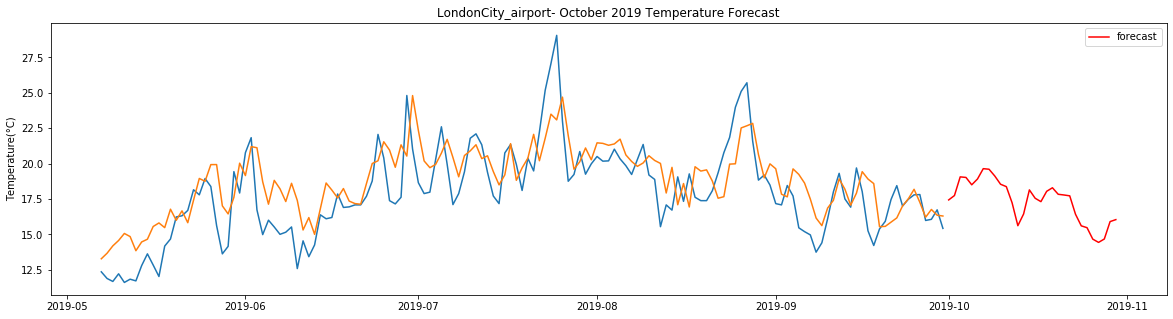

Lyneham_airport total samples:  5355
Training samples:  4284
Testing samples:  1071
r-square_SVR_Test:  0.87


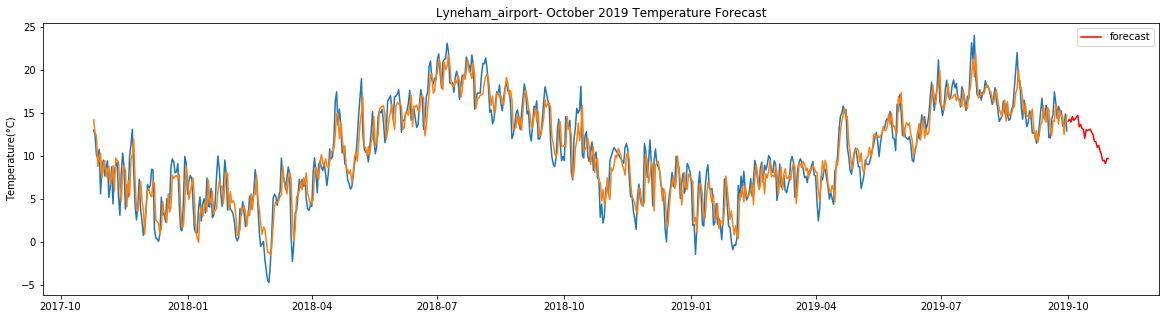

NewquayCornwall_airport total samples:  2556
Training samples:  2044
Testing samples:  512
r-square_SVR_Test:  0.64


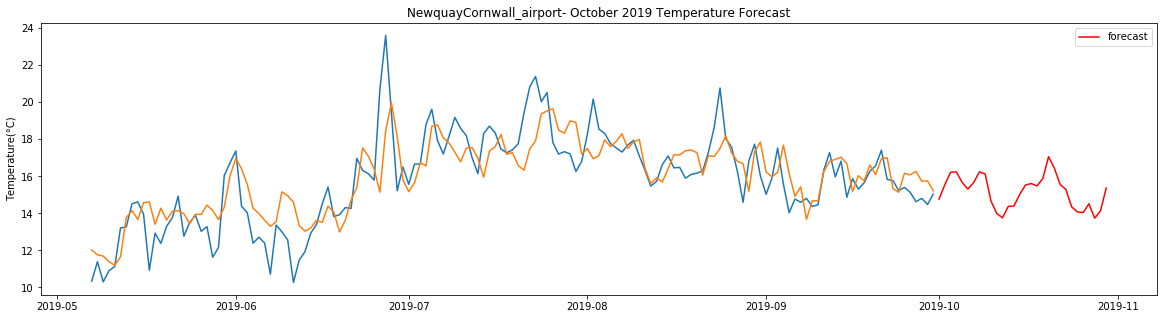

Norwich_airport total samples:  2556
Training samples:  2044
Testing samples:  512
r-square_SVR_Test:  0.54


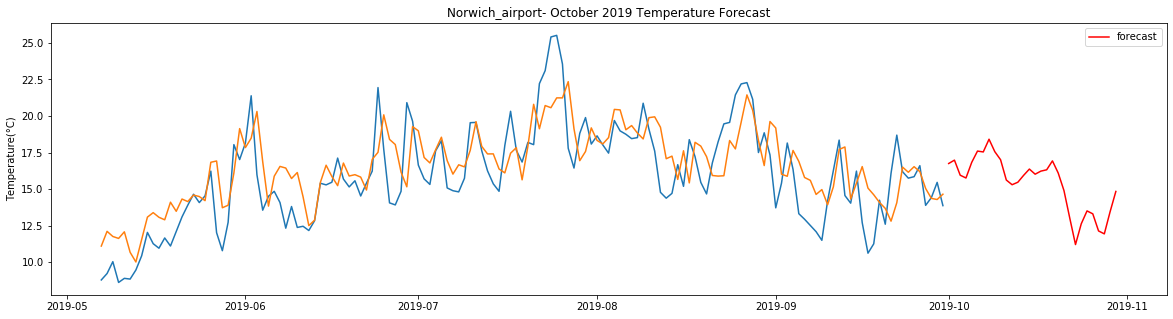

Nottingham total samples:  5355
Training samples:  4284
Testing samples:  1071
r-square_SVR_Test:  0.87


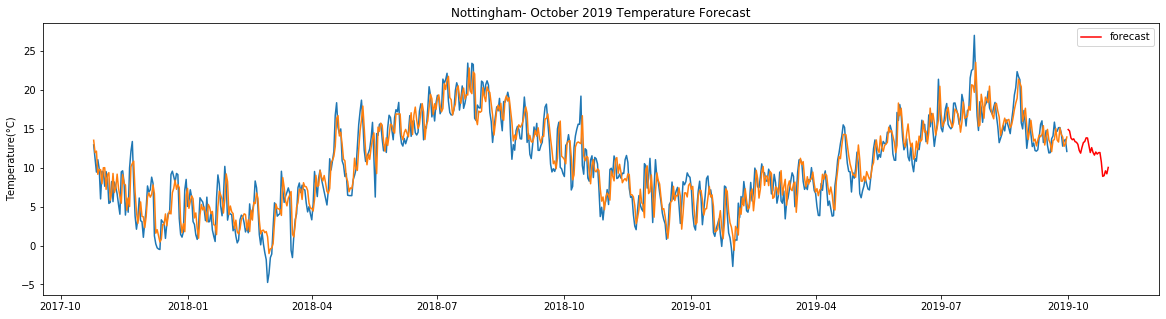

Plymouth_weatherstation total samples:  5355
Training samples:  4284
Testing samples:  1071
r-square_SVR_Test:  0.87


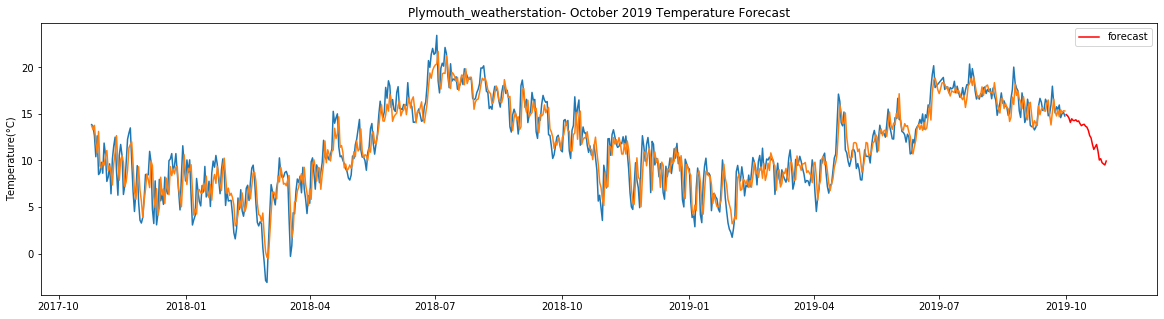

Rostherne total samples:  2495
Training samples:  1996
Testing samples:  499
r-square_SVR_Test:  0.5


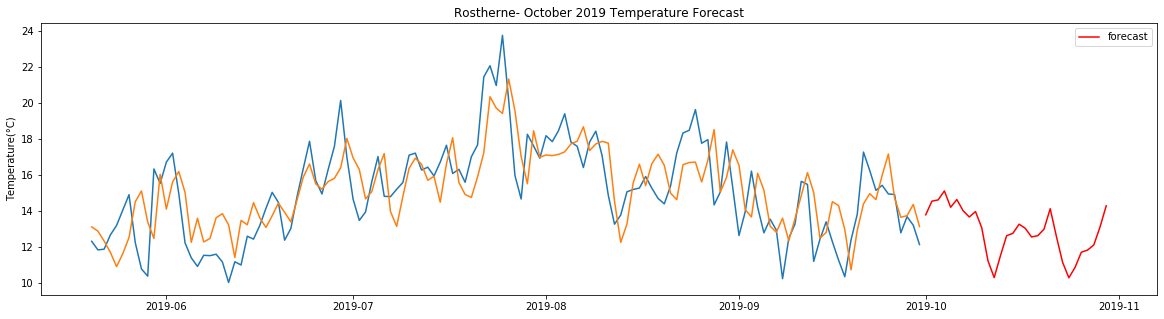

Scampton_airport total samples:  3543
Training samples:  2834
Testing samples:  709
r-square_SVR_Test:  0.79


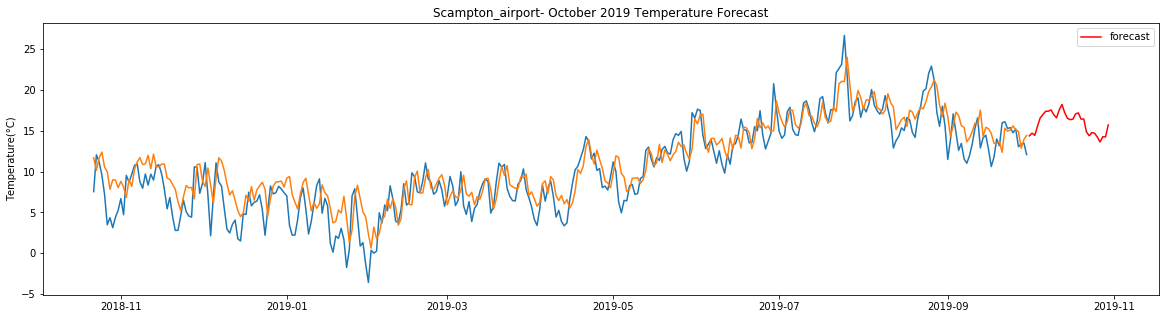

Shawbury_airport total samples:  5355
Training samples:  4284
Testing samples:  1071
r-square_SVR_Test:  0.84


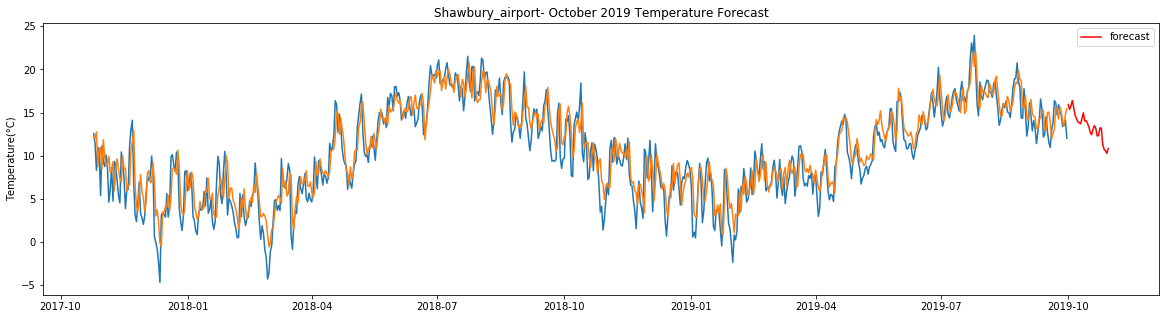

Southend_on_Sea_AWS total samples:  3648
Training samples:  2918
Testing samples:  730
r-square_SVR_Test:  0.86


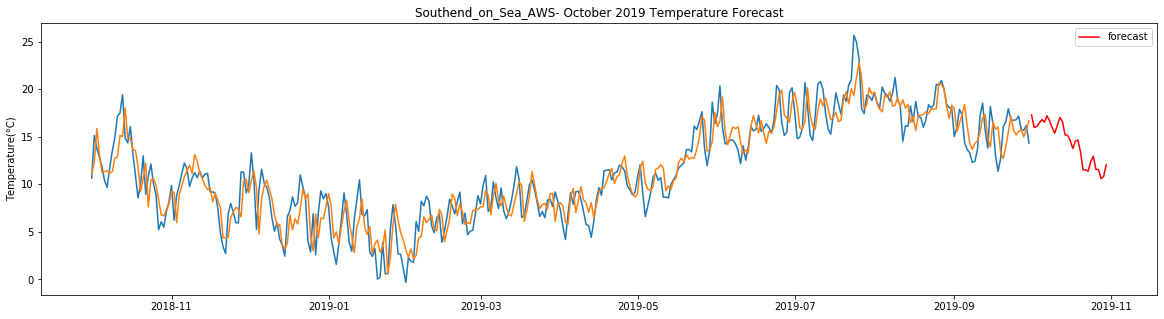

Stansted_airport total samples:  2556
Training samples:  2044
Testing samples:  512
r-square_SVR_Test:  0.53


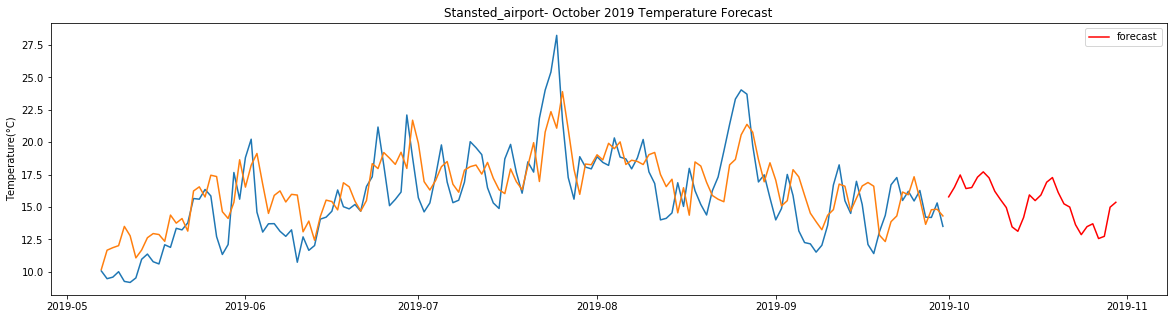

Wittering_airport total samples:  5355
Training samples:  4284
Testing samples:  1071
r-square_SVR_Test:  0.87


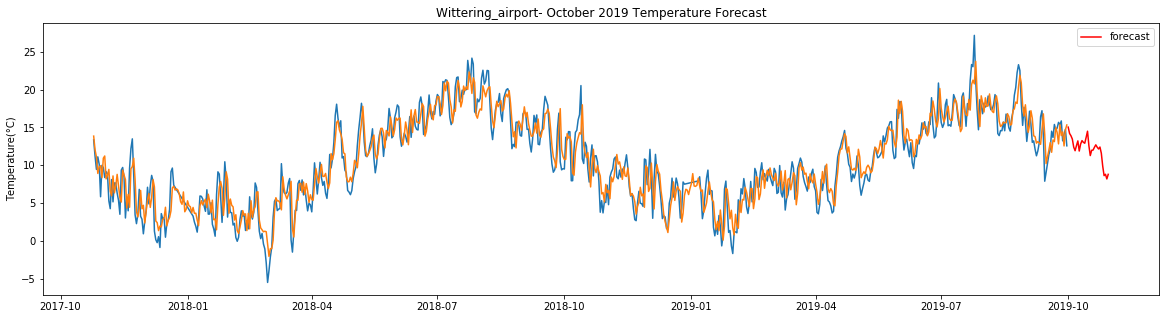

Yeovilton_airport total samples:  5355
Training samples:  4284
Testing samples:  1071
r-square_SVR_Test:  0.84


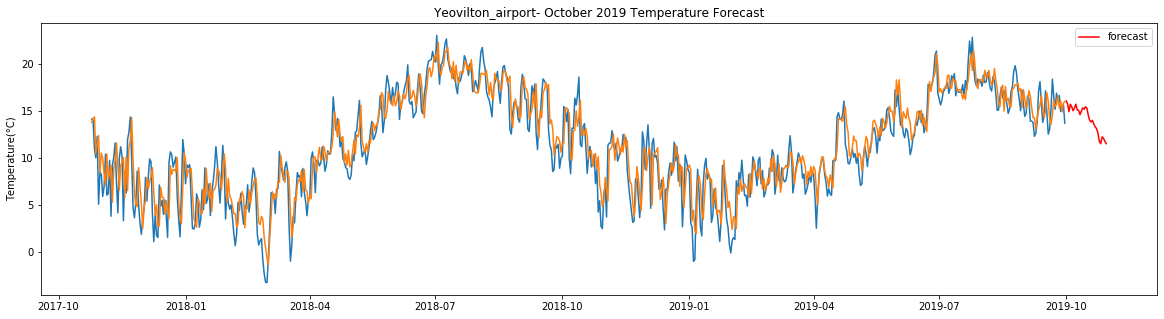

Wall time: 4min 14s


In [35]:
%%time
# Fitting and forecast using SVM
svr_prediction = england_temp_svr(all_station_temp, 365, 30)

In the above section the SVR model is trained on past time series data followed by forecasting temperature for the month of October,2019 for each of the stations. The results are plotted for each station with past observed temperatures in Blue, validation in Orange and forecast in Red. The validation closely matches the observed daily temperatures in most of the cases as also given by the test metrics of r-square with the highest values reaching upto 0.87 for the SVR model.    

## Temperature forecasted by SVR model <a class="anchor" id="14"></a>
The output obtained by the above SVR model is visualized here which will now be processed to interpolate temperature for the whole of England. 

In [36]:
# Daily forecast obtained from the SVR model for each of the weather stations
svr_prediction.head()

Albemarle  Begwary  Birmingham_airport  Blackpool_airport  \
2019-10-01      11.29    14.30               14.97              13.83   
2019-10-02       9.78    13.69               15.44              14.48   
2019-10-03      10.47    14.45               16.59              14.63   
2019-10-04      11.32    14.62               16.02              14.73   
2019-10-05      12.70    14.27               15.56              14.95   

            Boulmer_airport  Bournemouth_airport  BrizeNorton_airport  \
2019-10-01            16.18                14.08                14.59   
2019-10-02            16.82                15.33                14.74   
2019-10-03            16.61                16.64                14.21   
2019-10-04            15.88                17.02                14.25   
2019-10-05            15.98                16.04                13.76   

            Cardiff_airport  Carlisle  Crosby  ...  Norwich_airport  \
2019-10-01            15.45     12.60   14.45  ...            16.75   
2019-10-02            15.87     13.01   14.21  ...            16.98   
2019-10-03            16.83     14.01   15.27  ...            15.95   
2019-10-04            17.63     14.07   15.91  ...            15.76   
2019-10-05            17.65     14.55   15.56  ...            16.83   

            Nottingham  Plymouth_weatherstation  Rostherne  Scampton_airport  \
2019-10-01       14.93                    14.93      13.77             14.37   
2019-10-02       14.74                    14.80      14.53             14.70   
2019-10-03       13.84                    14.56      14.60             14.43   
2019-10-04       13.62                    14.09      15.10             15.55   
2019-10-05       13.73                    14.48      14.19             16.57   

            Shawbury_airport  Southend_on_Sea_AWS  Stansted_airport  \
2019-10-01             15.94                17.29             15.78   
2019-10-02             15.38                15.99             16.52   
2019-10-03             15.76                16.06             17.47   
2019-10-04             16.40                16.43             16.42   
2019-10-05             15.57                16.80             16.50   

            Wittering_airport  Yeovilton_airport  
2019-10-01              15.03              16.06  
2019-10-02              14.19              15.77  
2019-10-03              13.89              14.92  
2019-10-04              13.45              15.71  
2019-10-05              12.39              15.46  

[5 rows x 29 columns]

## Temperature Interpolation for England <a class="anchor" id="15"></a>

Now the predictions obtained by the SVM method would be used for spatially mapping and estimating temperatures for the entire country for a certain day. Hence location of each weather station needs to be added to this table for the spatial operation. This is done in the following.    

In [37]:
# Change station names to index
england_temp_forecast = svr_prediction.transpose()
england_temp_forecast.head()

2019-10-01  2019-10-02  2019-10-03  2019-10-04  \
Albemarle                11.29        9.78       10.47       11.32   
Begwary                  14.30       13.69       14.45       14.62   
Birmingham_airport       14.97       15.44       16.59       16.02   
Blackpool_airport        13.83       14.48       14.63       14.73   
Boulmer_airport          16.18       16.82       16.61       15.88   

                    2019-10-05  2019-10-06  2019-10-07  2019-10-08  \
Albemarle                12.70       11.92       12.31       11.09   
Begwary                  14.27       14.83       14.79       14.78   
Birmingham_airport       15.56       16.25       15.62       14.85   
Blackpool_airport        14.95       15.49       15.65       14.91   
Boulmer_airport          15.98       15.66       15.07       15.07   

                    2019-10-09  2019-10-10  ...  2019-10-21  2019-10-22  \
Albemarle                10.37       11.27  ...       10.10        8.66   
Begwary                  13.96       13.87  ...       13.37       13.34   
Birmingham_airport       14.52       13.72  ...       14.49       13.28   
Blackpool_airport        14.62       14.74  ...       13.00       12.17   
Boulmer_airport          16.59       16.54  ...       15.98       16.55   

                    2019-10-23  2019-10-24  2019-10-25  2019-10-26  \
Albemarle                 7.59        7.29        7.71        6.78   
Begwary                  12.98       13.82       14.66       13.47   
Birmingham_airport       12.20       11.94       12.49       11.57   
Blackpool_airport        11.50       11.88       11.62       10.88   
Boulmer_airport          16.74       15.89       14.46       14.66   

                    2019-10-27  2019-10-28  2019-10-29  2019-10-30  
Albemarle                 6.19        6.30        7.15        8.40  
Begwary                  12.06       12.06       11.56       11.54  
Birmingham_airport       12.07       12.16       13.45       14.49  
Blackpool_airport        11.11       10.96       11.32       12.13  
Boulmer_airport          15.04       16.14       17.12       16.28  

[5 rows x 30 columns]

In [38]:
# Make station names to a column
england_temp_forecast_station = england_temp_forecast.reset_index()
england_temp_forecast_station = england_temp_forecast_station.rename(columns={'index':'Station'})
england_temp_forecast_station.head()

Station  2019-10-01 00:00:00  2019-10-02 00:00:00  \
0           Albemarle                11.29                 9.78   
1             Begwary                14.30                13.69   
2  Birmingham_airport                14.97                15.44   
3   Blackpool_airport                13.83                14.48   
4     Boulmer_airport                16.18                16.82   

   2019-10-03 00:00:00  2019-10-04 00:00:00  2019-10-05 00:00:00  \
0                10.47                11.32                12.70   
1                14.45                14.62                14.27   
2                16.59                16.02                15.56   
3                14.63                14.73                14.95   
4                16.61                15.88                15.98   

   2019-10-06 00:00:00  2019-10-07 00:00:00  2019-10-08 00:00:00  \
0                11.92                12.31                11.09   
1                14.83                14.79                14.78   
2                16.25                15.62                14.85   
3                15.49                15.65                14.91   
4                15.66                15.07                15.07   

   2019-10-09 00:00:00  ...  2019-10-21 00:00:00  2019-10-22 00:00:00  \
0                10.37  ...                10.10                 8.66   
1                13.96  ...                13.37                13.34   
2                14.52  ...                14.49                13.28   
3                14.62  ...                13.00                12.17   
4                16.59  ...                15.98                16.55   

   2019-10-23 00:00:00  2019-10-24 00:00:00  2019-10-25 00:00:00  \
0                 7.59                 7.29                 7.71   
1                12.98                13.82                14.66   
2                12.20                11.94                12.49   
3                11.50                11.88                11.62   
4                16.74                15.89                14.46   

   2019-10-26 00:00:00  2019-10-27 00:00:00  2019-10-28 00:00:00  \
0                 6.78                 6.19                 6.30   
1                13.47                12.06                12.06   
2                11.57                12.07                12.16   
3                10.88                11.11                10.96   
4                14.66                15.04                16.14   

   2019-10-29 00:00:00  2019-10-30 00:00:00  
0                 7.15                 8.40  
1                11.56                11.54  
2                13.45                14.49  
3                11.32                12.13  
4                17.12                16.28  

[5 rows x 31 columns]

In [39]:
# Join forecast temperature data to weather station location using the Staion column
predicted_temp_by_station = pd.merge(england_temp_forecast_station, england_weather_stations_layer_sdf, left_on='Station', right_on='Station', how='left')
predicted_temp_by_station.head()

Station  2019-10-01 00:00:00  2019-10-02 00:00:00  \
0           Albemarle                11.29                 9.78   
1             Begwary                14.30                13.69   
2  Birmingham_airport                14.97                15.44   
3   Blackpool_airport                13.83                14.48   
4     Boulmer_airport                16.18                16.82   

   2019-10-03 00:00:00  2019-10-04 00:00:00  2019-10-05 00:00:00  \
0                10.47                11.32                12.70   
1                14.45                14.62                14.27   
2                16.59                16.02                15.56   
3                14.63                14.73                14.95   
4                16.61                15.88                15.98   

   2019-10-06 00:00:00  2019-10-07 00:00:00  2019-10-08 00:00:00  \
0                11.92                12.31                11.09   
1                14.83                14.79                14.78   
2                16.25                15.62                14.85   
3                15.49                15.65                14.91   
4                15.66                15.07                15.07   

   2019-10-09 00:00:00  ...  2019-10-25 00:00:00  2019-10-26 00:00:00  \
0                10.37  ...                 7.71                 6.78   
1                13.96  ...                14.66                13.47   
2                14.52  ...                12.49                11.57   
3                14.62  ...                11.62                10.88   
4                16.59  ...                14.46                14.66   

   2019-10-27 00:00:00  2019-10-28 00:00:00  2019-10-29 00:00:00  \
0                 6.19                 6.30                 7.15   
1                12.06                12.06                11.56   
2                12.07                12.16                13.45   
3                11.11                10.96                11.32   
4                15.04                16.14                17.12   

   2019-10-30 00:00:00  FID          Y         X  \
0                 8.40    1  55.016667 -1.866667   
1                11.54    2  52.216667 -0.483333   
2                14.49    3  52.450000 -1.733333   
3                12.13    4  53.766667 -3.033333   
4                16.28    5  55.420300 -1.599700   

                                               SHAPE  
0  {'x': -207796.38285121127, 'y': 7365101.445978...  
1  {'x': -53804.420512971476, 'y': 6839396.777444...  
2  {'x': -192953.78400456344, 'y': 6881903.804921...  
3  {'x': -337669.1220358203, 'y': 7126089.0211904...  
4  {'x': -178077.78942199165, 'y': 7443868.808735...  

[5 rows x 35 columns]

## Result Visualization <a class="anchor" id="16"></a>

Now the table above gives the daily temperature forecast for the month of October,2019 for all the 29 weather stations in England, with location of each station. Out of these predictions the first day of October is selected for creating a probable temperature surface for the entire country.

In [40]:
# Select the first day out 
oct1st_temp = predicted_temp_by_station.iloc[:, [0,1,33,32]]
oct1st_temp = oct1st_temp.rename(columns={oct1st_temp.columns[1]:'temp_pred'})
oct1st_temp.head()

Station  temp_pred         X          Y
0           Albemarle      11.29 -1.866667  55.016667
1             Begwary      14.30 -0.483333  52.216667
2  Birmingham_airport      14.97 -1.733333  52.450000
3   Blackpool_airport      13.83 -3.033333  53.766667
4     Boulmer_airport      16.18 -1.599700  55.420300

The data is now converted into a spatial data frame in the following. 

In [41]:
# convert dataframe to a spatial dataframe
sdf = oct1st_temp.spatial.from_xy(df=oct1st_temp, sr=4326, x_column='X', y_column='Y')
# create feature layer from the spatial dataframe
oct1st_temp_points = gis.content.import_data(sdf, title='eng_temp_points')

In [42]:
oct1st_temp_points

<Item title:"eng_temp_points" type:Feature Layer Collection owner:arcgis_python>

The [interpolate_points](https://developers.arcgis.com/python/api-reference/arcgis.features.analysis.html?highlight=interpolate%20points#arcgis.features.analysis.interpolate_points) method from the ArcGIS API for Python allows us to predict values at new locations based on measurements from a collection of points. The method takes point data with values at each point and returns areas classified by predicted values. 

For example, we are using interpolate_points tool to estimate temperature of England.
The input parameters required for the tool are:
- `input_layer`: feature layer having the predicted temperature for all the weather stations
- interpolate_options specify the speed v/s accuracy on a range of 1 to 9 with 9 as the maximum accuracy
- field indicates the column name in the feature layer which has the predicted temperatures
- bounding_polygon_layer here is the England boundary shapefile which sets the boundary within which the spatial interpolation would be estimated
- finally the name of the resulting output interpolated surface.  


In [43]:
# Interpolate the predicted temperature data to create forecast surface for England
oct1st_temp_surface = interpolate_points(oct1st_temp_points, 
                                         interpolate_option=9,                                         
                                         field='temp_pred', 
                                         bounding_polygon_layer=england_boundary_layer,
                                         output_name='Interpolated Temperature'+ str(datetime.now().microsecond))

In [44]:
oct1st_temp_surface

<Item title:"Interpolated Temperature558120" type:Feature Layer Collection owner:arcgis_python>


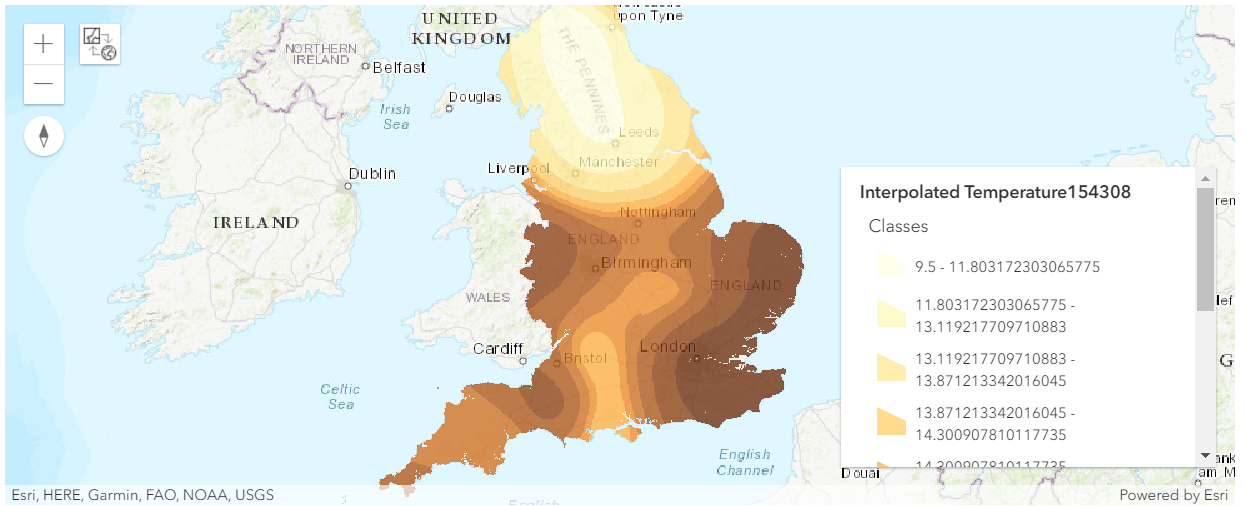

In [48]:
# Plot the interpolated temperature surface
eng_interpolated_temp = gis.map('England', zoomlevel=6)
eng_interpolated_temp.add_layer(oct1st_temp_surface)
eng_interpolated_temp.legend = True
eng_interpolated_temp

The interpolated forecast temperature surface above for England shows that temperature gradually increases from the northern to the southern part of the country, and ranges from a minimum of 9.5 degrees to a maximum of 17.43 degree Celsius respectively, with two distinct zones dividing the country. Lower temperatures are prevalent in the interior part of the country compared to the coastal belts, with London falling in the maximum temperature zone. This is expected since coastal regions are usually warmer than inland areas due to different climatic conditions.  

## Conclusion<a class="anchor" id="17"></a>

In this notebook a timeseries temperature dataset was used to predict daily temperature for England for the month of October using historic data from 29 weather stations. Two methods were used for the study — first a deep learning framework of LSTM was used followed by a machine learning method of Support Vector Regression. Both the models were able to model the data relatively well as evident from the high accuracy obtained for both train and test set. However the SVM model was consistently performing better than the LSTM model with higher accuracy. Some instances of low accuracy for both the models were caused for certain stations due to less training data points available. 

Similarly interesting differences were observed while forecasting daily temperatures using the two models. Here the SVR model was able to capture the daily fluctuations in greater detail which looked more real compared to the forecast returned by the LSTM model, as observed from the forecast plots. Besides, the total run time for the SVR model for fitting the data was only  a few minutes and was far less than the time taken by the LSTM model, which was training for 100 epochs for each station. 

Finally the sample shows how deep learning or machine learning models could be combined with spatial tools in ArcGIS to process timeseries data and produce meaningful results that could be valuable for various industry verticals. 

### Summary of methods used <a class="anchor" id="18"></a>

| Method | Question | Examples |
| -| - |-|
| interpolate_points| What is the value of any points located between other given points?  |Predicting temperature at any intermediate location based on measurement from surrounding station |


### Data resources <a class="anchor" id="19"></a>

| Shapefile | Source | Link |
| -| - |-|
| england_border| Counties and Unitary Authorities (December 2016) Full Clipped Boundaries in England and Wales  |https://data.gov.uk|
| england_weather_stations| Weather for 243 countries of the world  |https://rp5.ru/Weather_in_the_world|
| table(england historic weather data)| Weather for 243 countries of the world  |https://rp5.ru/Weather_in_the_world|   

| Articles | Source | Link |
| -| - |-|
| LONG SHORT-TERM MEMORY| Neural Computation 9(8):1735{1780, 1997  |http://www.bioinf.jku.at/publications/older/2604.pdf|
| Support Vector Regression Machines | Bell Labs and Monmouth University Department of Electronic Engineering |https://papers.nips.cc/paper/1238-support-vector-regression-machines.pdf|

